# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles

**Objectifs** : Comparer les modèles et générer des tags pour chacun d'entre eux

## <font color="#114b98">Sommaire</font>
[1. Chargement et préparation du jeu de données](#section_1)

[2. Approche non supervisée : LDA & NMF](#section_2)

[3. Approche non supervisée : RAKE](#section_3)

[4. Approche supervisée : Classifiers](#section_4)

[5. Approche supervisée : Doc2Vec](#section_5)

[6. Approche supervisée : Word2Vec](#section_6)

[7. Approche supervisée : BERT](#section_7)

[8. Approche supervisée : USE](#section_8)

[9. Choix du modèle pour le code final à déployer](#section_9)

[10. Préparation de la pipeline de prédiction](#section_10)

## <font color="#114b98" id="section_1">1. Chargement et préparation du jeu de données</font>

In [196]:
import os
import ast
import sys
import copy
import time
import torch
import psutil
import sklearn
import numpy as np
import pandas as pd
import pkg_resources
import seaborn as sns
import multiprocessing
import tensorflow as tf
from statistics import mean
from tensorflow import keras
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [197]:
print("System Version: ",sys.version)
print("Scikit-learn Version: ",sklearn.__version__)
print("Tensorflow Version: ", tf.__version__)
print("Keras Version: ", tf.keras.__version__)
print("PyTorch Version: ", torch.__version__)
print("Num CPUs Available: ", multiprocessing.cpu_count())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Tensorflow build with CUDA:", tf.test.is_built_with_cuda())
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs: " + ", ".join([gpu.name for gpu in tf.config.list_physical_devices('GPU')]))
print("Available CPU memory:", psutil.virtual_memory())
if tf.config.list_physical_devices('GPU'):
    for gpu in gpus:
        print(f"Available memory in {gpu.name}: ", tf.compat.v1.cuda.get_device_properties(gpu).total_memory)
print("Current working directory:", os.getcwd())
disk = psutil.disk_usage('/')
print("Available disk space: {} GB".format(round(disk.free / 1024**3, 2)))

System Version:  3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
Scikit-learn Version:  1.0.2
Tensorflow Version:  2.11.0
Keras Version:  2.11.0
PyTorch Version:  1.13.1+cpu
Num CPUs Available:  4
Num GPUs Available:  0
Tensorflow build with CUDA: False
Available GPUs: 
Available CPU memory: svmem(total=17066909696, available=9791528960, percent=42.6, used=7275380736, free=9791528960)
Current working directory: D:\Mega\Z_Simon\5 - WORK\2 - Jupyter
Available disk space: 227.71 GB


In [198]:
# %load_ext pycodestyle_magic
# %pycodestyle_on

In [199]:
plt.rc('axes', titlesize=22)
plt.rc('axes', labelsize=18)
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [200]:
# main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
main_path = 'D:/Mega/Z_Simon/5 - WORK/1 - Projets/Projet 5/'
data = pd.read_csv(main_path+'saved_ressources/data_cleaned_500tags.csv', encoding='utf8')

In [201]:
data["Texts"] = data["Texts"].apply(lambda x: ast.literal_eval(x))
data["Tags"] = data["Tags"].apply(lambda x: ast.literal_eval(x))
data.head()

,Tags,Texts,Sentences
0,"[python, django, string, json]","[python, json, string, json, django, json, str...",python json boolean to lowercase string is the...
1,"[java, html, input, validation]","[java, html, input, validation, input, java, v...",is there a java implementation of the html5 in...
2,"[java, python, ruby, docker]","[docker, python, java, ruby, docker, python, j...",encoding problems when running an app in docke...
3,"[python, list, performance, dictionary]","[python, list, list, dictionary, list, diction...","python dictionary vs list, which is faster? i ..."
4,"[ruby, class, inheritance, module]","[ruby, inheritance, class, class, module, clas...","ruby inheritance vs mixins in ruby, since you ..."


In [202]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Tags       40000 non-null  object
 1   Texts      40000 non-null  object
 2   Sentences  40000 non-null  object
dtypes: object(3)
memory usage: 937.6+ KB


Afin de mettre en place une méthode d’évaluation propre, je décide de séparer le jeu de données en deux parties : 
 - la première me servira à l'entrainement des modèles
 - la seconde partie me permettra d'évaluer certains modèles sur des données qui leurs sont inconnues

In [203]:
data_sample = data[0:6000]

In [204]:
texts_train, texts_eval, \
tags_train, tags_eval, \
sentences_train, sentences_eval = train_test_split(
    data_sample["Texts"],
    data_sample["Tags"],
    data_sample["Sentences"],    
    test_size=0.5,
    random_state=42
)

In [205]:
texts_list = texts_train.to_list()
tags_list = tags_train.to_list()
flat_texts = [" ".join(text) for text in texts_list]
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

In [206]:
mlb = MultiLabelBinarizer(classes=vocabulary_tags)
tags_mlb = mlb.fit_transform(tags_list)

In [207]:
texts_list_eval = texts_eval.to_list()
tags_list_eval = tags_eval.to_list()
flat_texts_eval = [" ".join(text) for text in texts_list_eval]
vocabulary_texts_eval = list(set([word for item in texts_list_eval for word in item]))

## <font color="#114b98" id="section_2">2. Approche non supervisée : LDA & NMF</font>

### Détermination du nombre de topics

In [15]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, jaccard_score, accuracy_score
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.matutils import corpus2dense
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [16]:
def optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test,
    and the list of texts, applies the models to the data and plots 
    the silhouette and coherence scores to help determine the optimal
    number of topics.

    """

    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    for n_topics in tqdm(n_topics_range, ascii=' >='):

        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, 
                                        max_iter=1000)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, 
                                           metric='euclidean'))

        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=1000)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, 
                                           metric='euclidean'))

        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, 
                                dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())

        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, 
                                dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())

    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'],
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], 
                                   n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], 
                                  n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle('Scores de Silhouette et de Coherence pour LDA et NMF avec {}'.format(str(vectorizer).split('(')[0]))
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()
    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()
    plt.show()

    return scores

In [17]:
# Define the range of number of topics to test
n_topics_range = range(12, 20, 4)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

In [18]:
# models_CountVectorizer = optimal_num_topics(flat_texts,
#                                             CountVectorizer(),
#                                             n_topics_range,
#                                             texts_list)
# models_CountVectorizer

TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

In [19]:
# models_TfidfVectorizer = optimal_num_topics(flat_texts,
#                                             TfidfVectorizer(vocabulary=vocabulary_texts),
#                                             n_topics_range,
#                                             texts_list)
# models_TfidfVectorizer

Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils sont davantage "interprétables par les humains".

Nous devons maintenant essayer d'obtenir des tags en utilisant ces méthodes.

Je choisis d'utiliser uniquement LDA pour la suite car c'est la méthode qui obtient les meilleurs scores de silhouette.

Je choisis le nombre de topics au regard des résultats précédents.

In [20]:
n_topics = 12

Le paramètre min_df définit le nombre minimum de documents dans lesquels un mot doit être présent pour être inclus dans le vocabulaire.

In [21]:
min_df = 5

Le paramètre max_df définit la fréquence maximale d'un mot en pourcentage de tous les documents. 

In [22]:
max_df = 0.99

### Visualisation des topics avec CountVectorizer

In [208]:
vectorizer_CV = CountVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
vcv = vectorizer_CV.fit_transform(flat_texts)
CV_feature_names = vectorizer_CV.get_feature_names()

In [209]:
n_top_words = 10

def plot_top_words(model, feature_names, n_top_words, title, color):
    fig, axes = plt.subplots(3, 4, figsize=(30, 25), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7, color=color)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

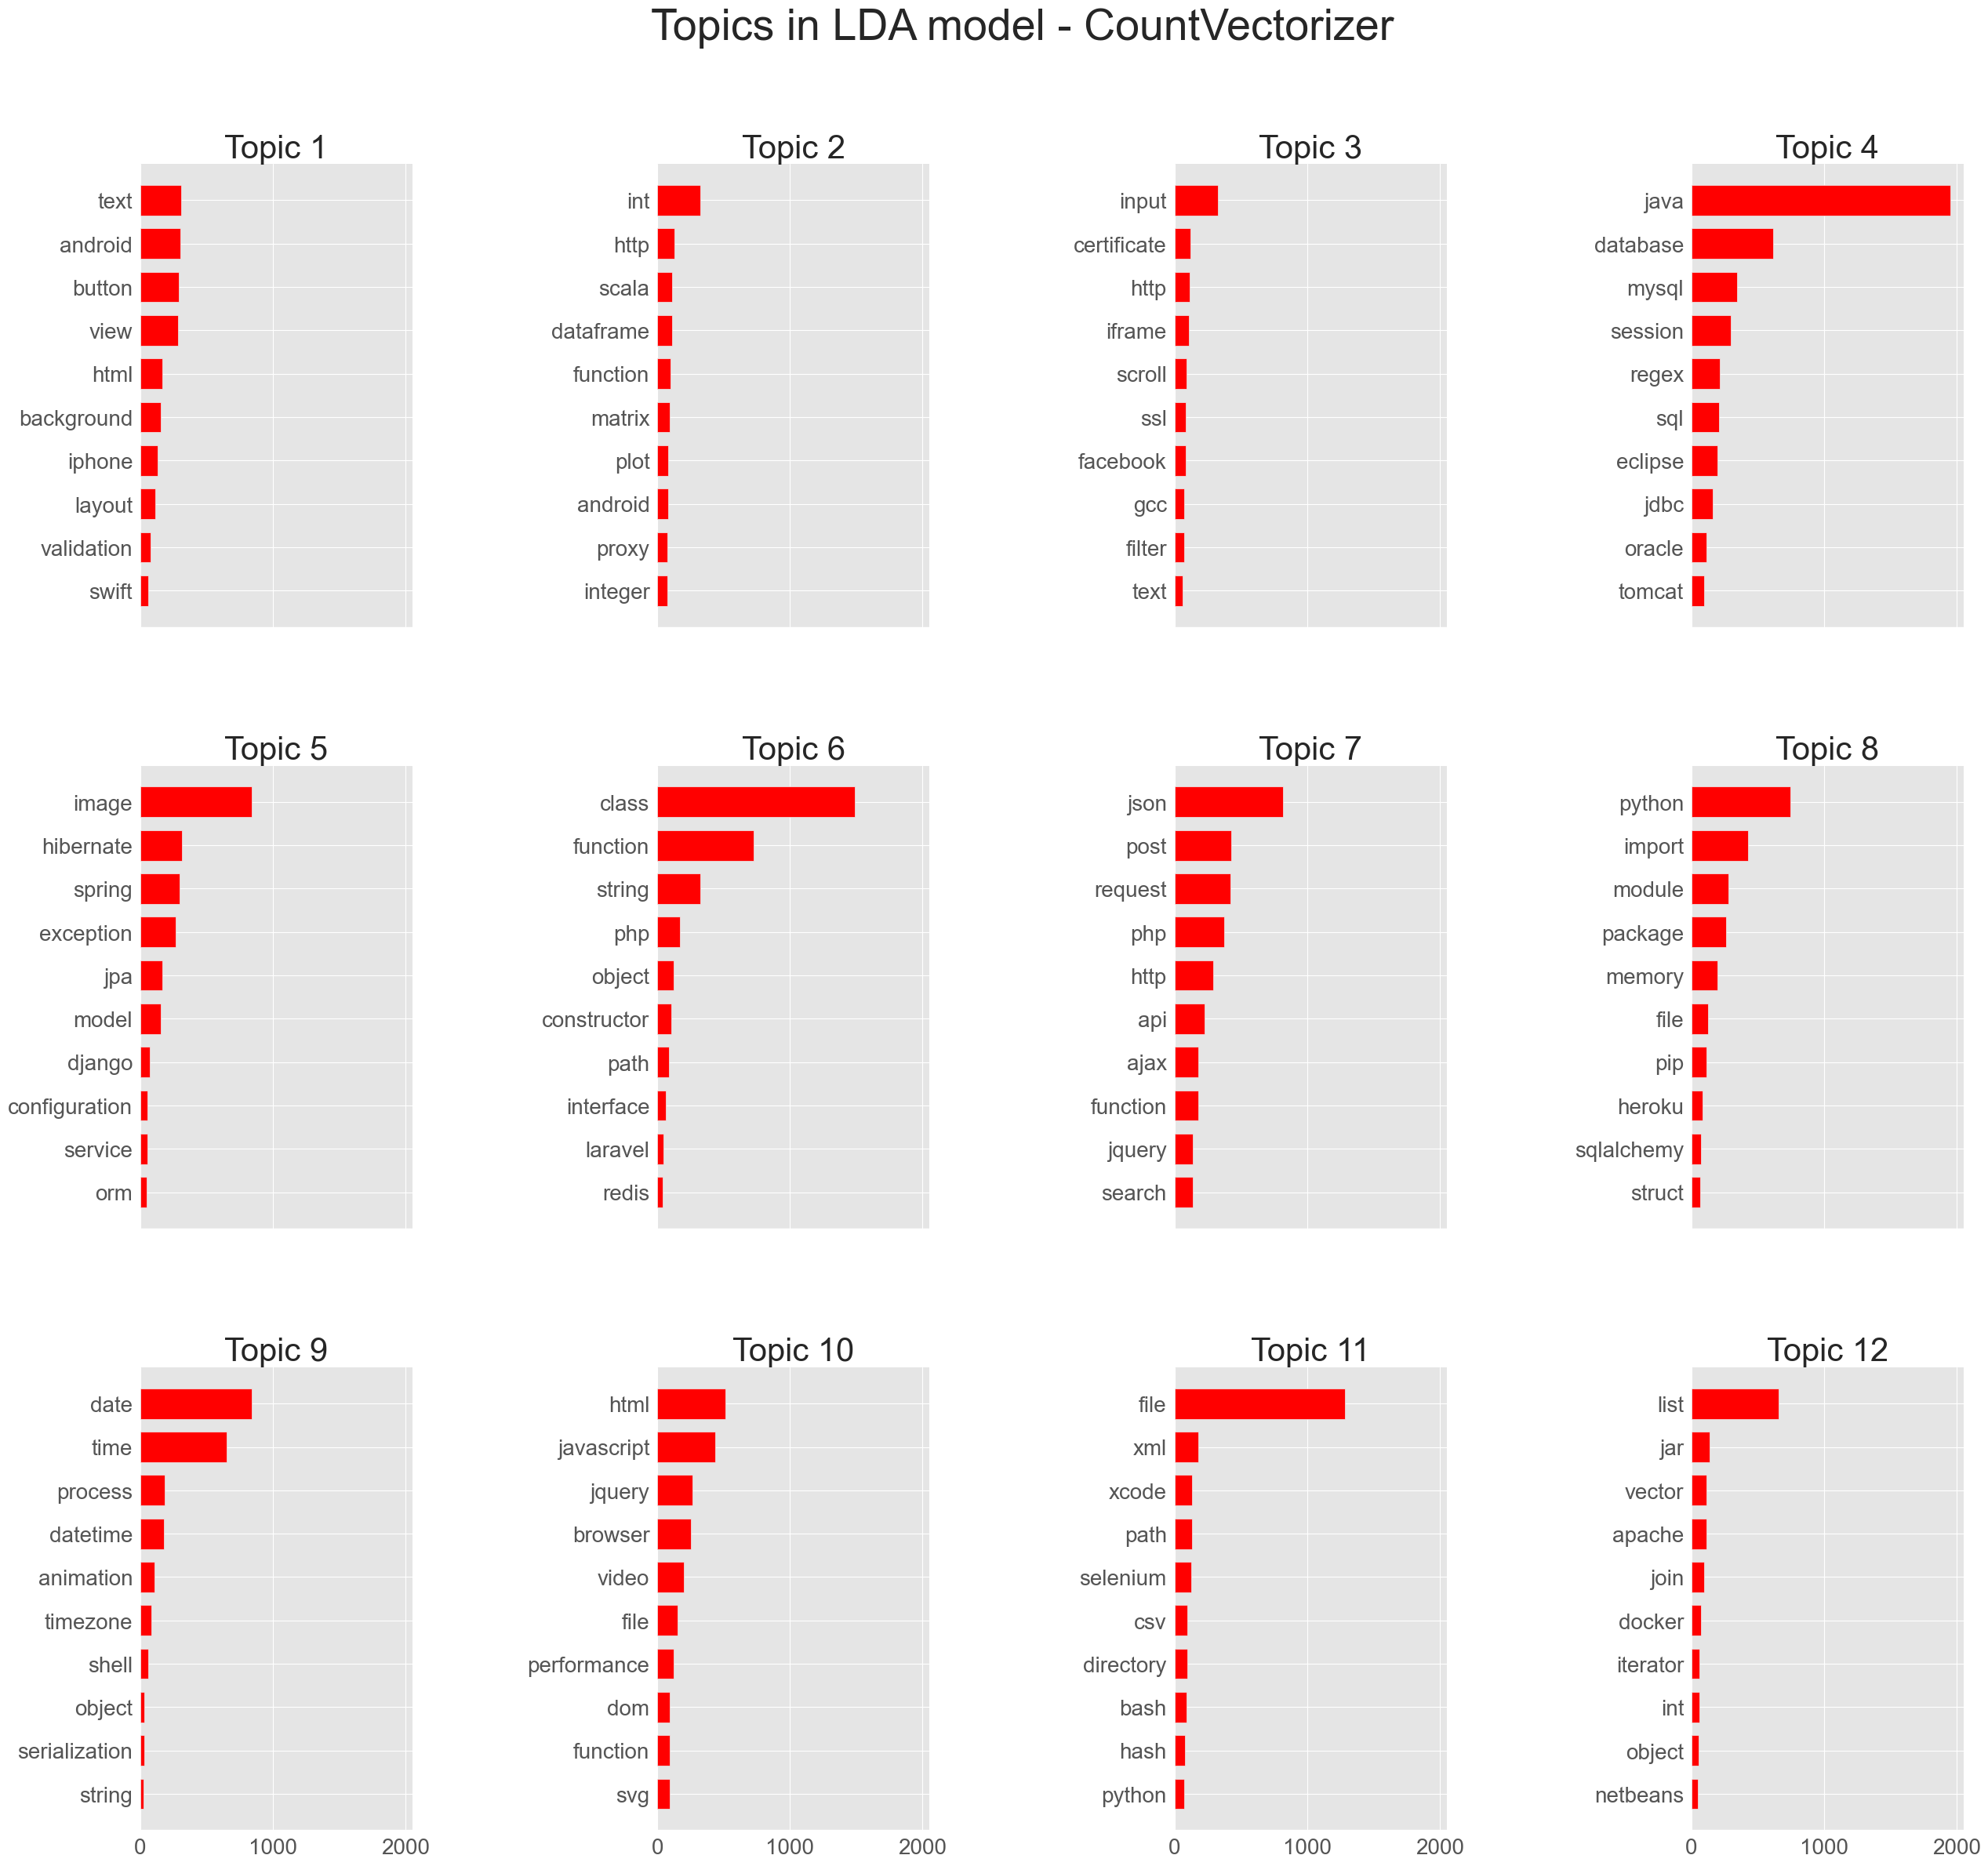

In [210]:
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                random_state=42).fit(vcv)

plot_top_words(lda, CV_feature_names, n_top_words, 'Topics in LDA model - CountVectorizer', 'red')

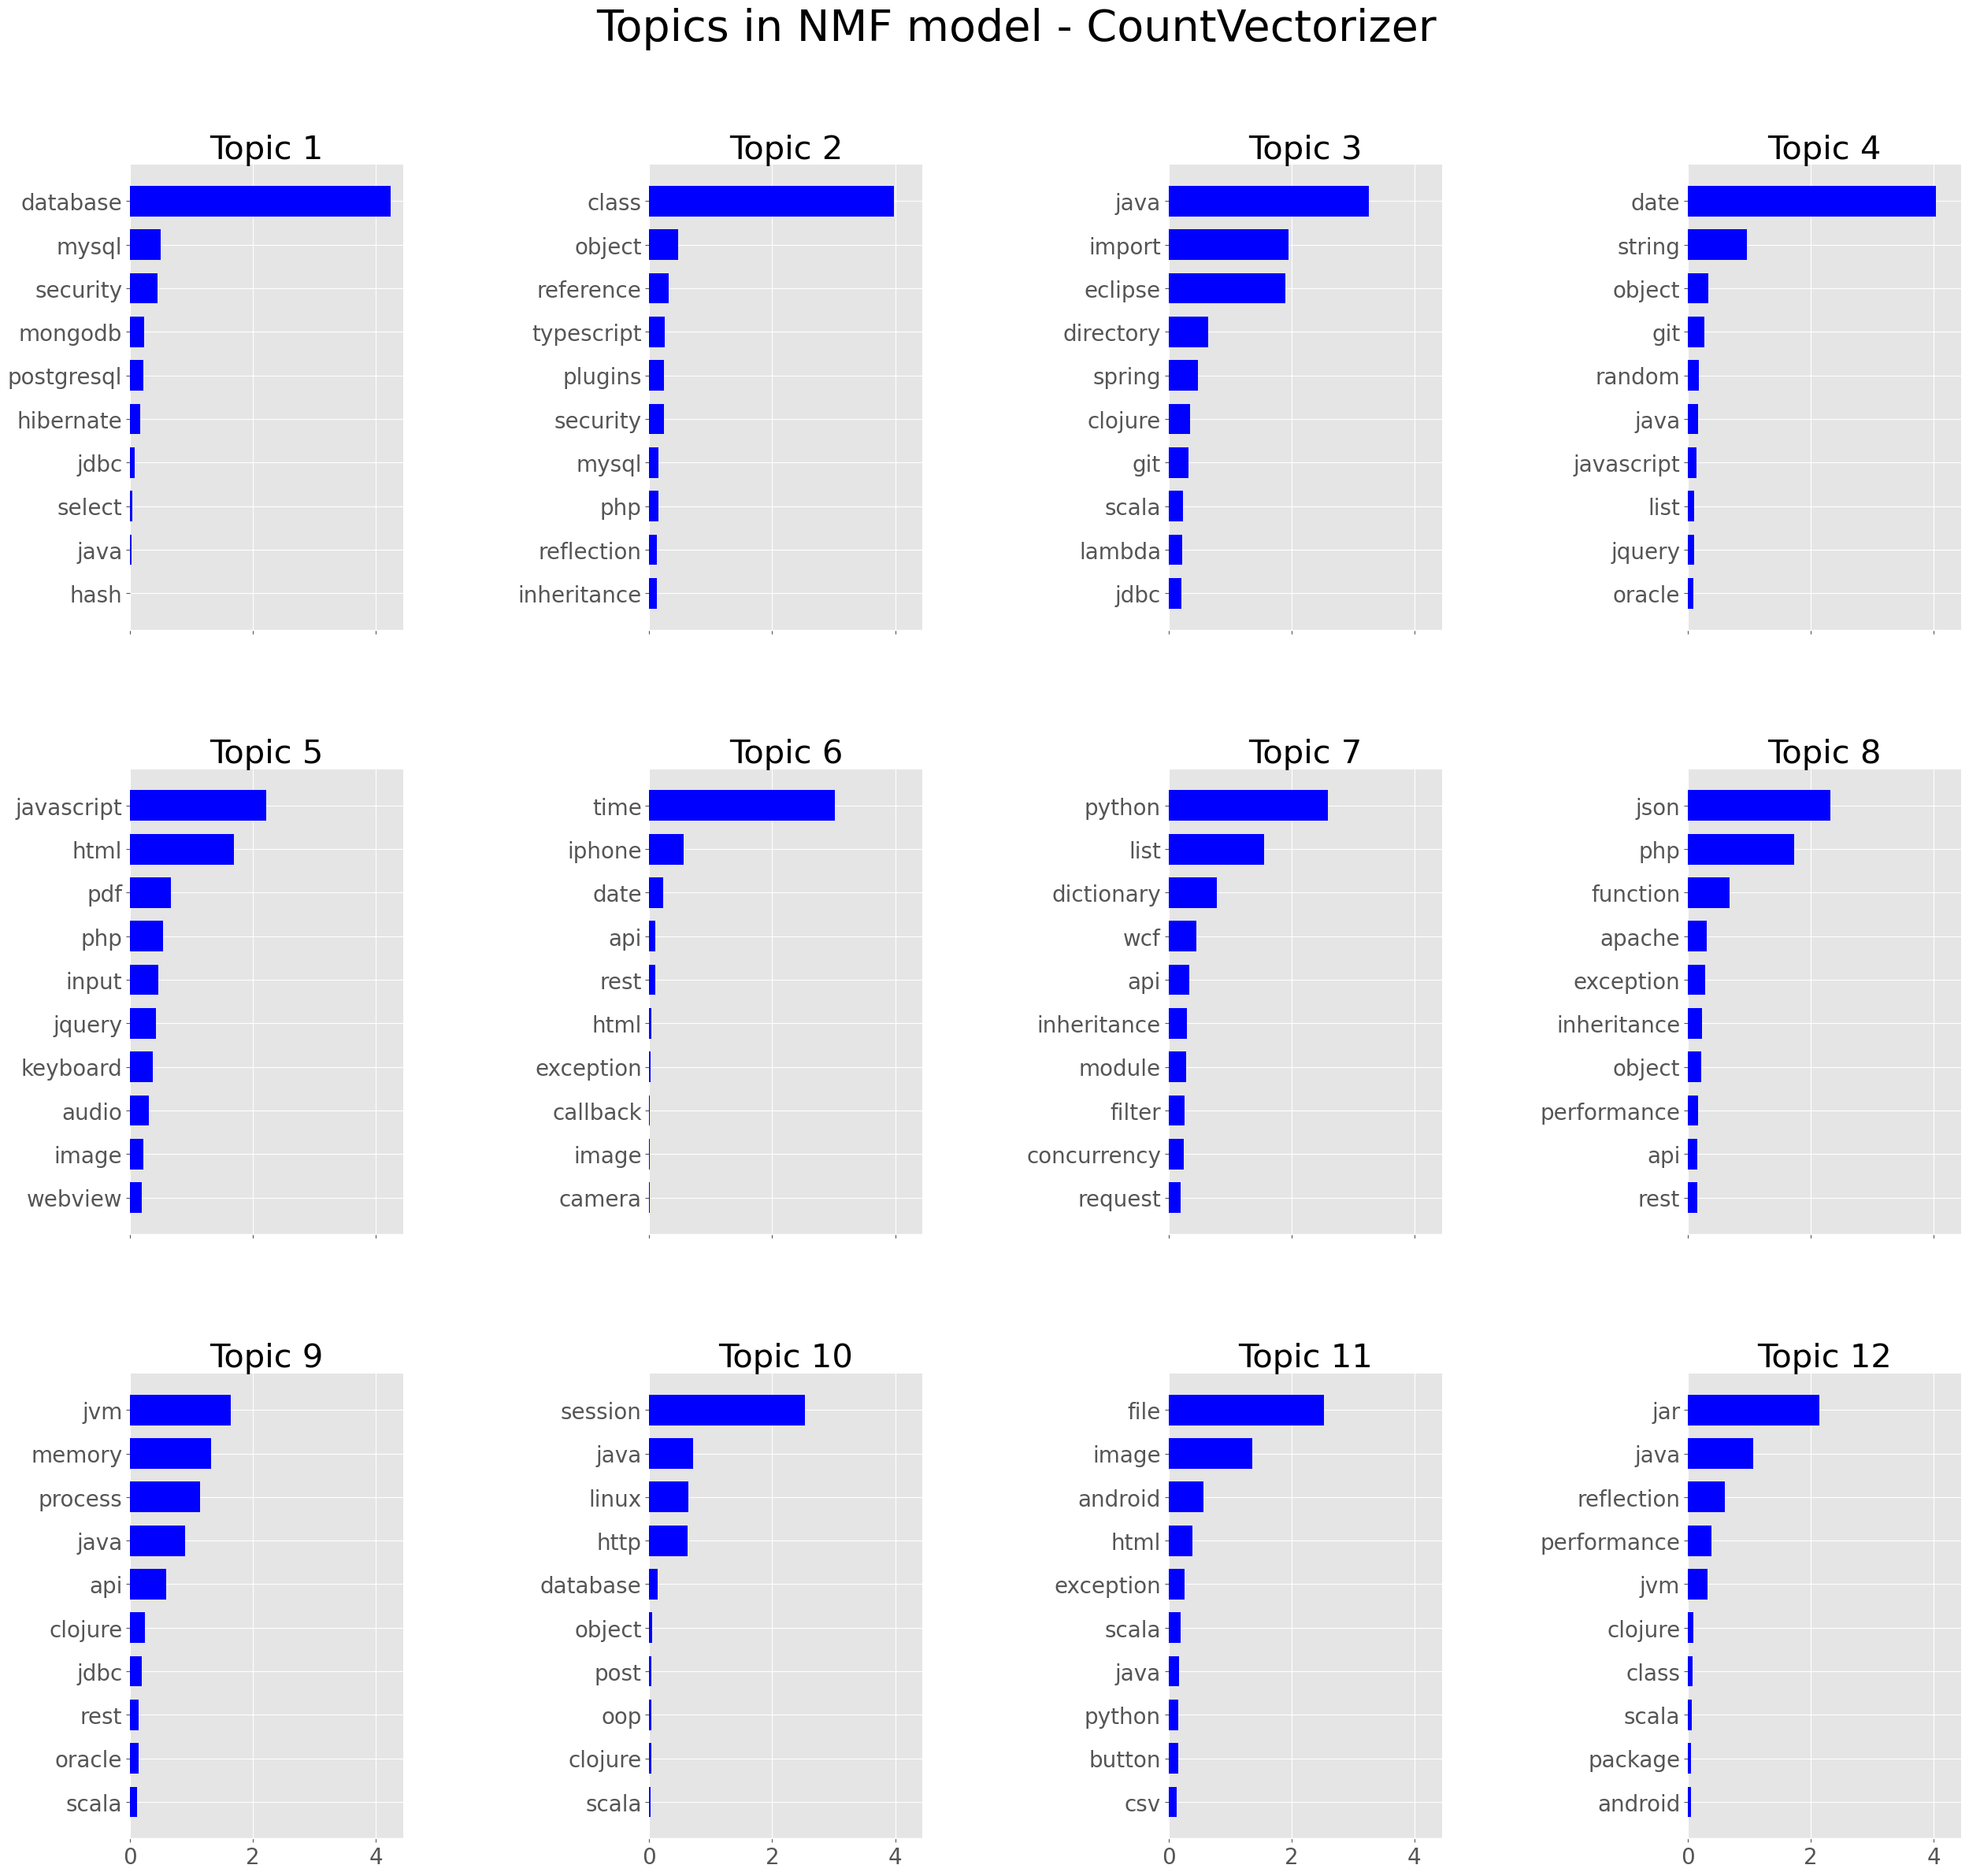

In [26]:
nmf = NMF(n_components=n_topics, random_state=42).fit(vcv)

plot_top_words(nmf, CV_feature_names, n_top_words,
               'Topics in NMF model - CountVectorizer', 'blue')

### Visualisation des topics avec TFIDF

In [211]:
vectorizer_TFIDF = TfidfVectorizer(vocabulary=vocabulary_texts, min_df=min_df, max_df=max_df)
tfidf = vectorizer_TFIDF.fit_transform(flat_texts)
TFIDF_feature_names = vectorizer_TFIDF.get_feature_names()

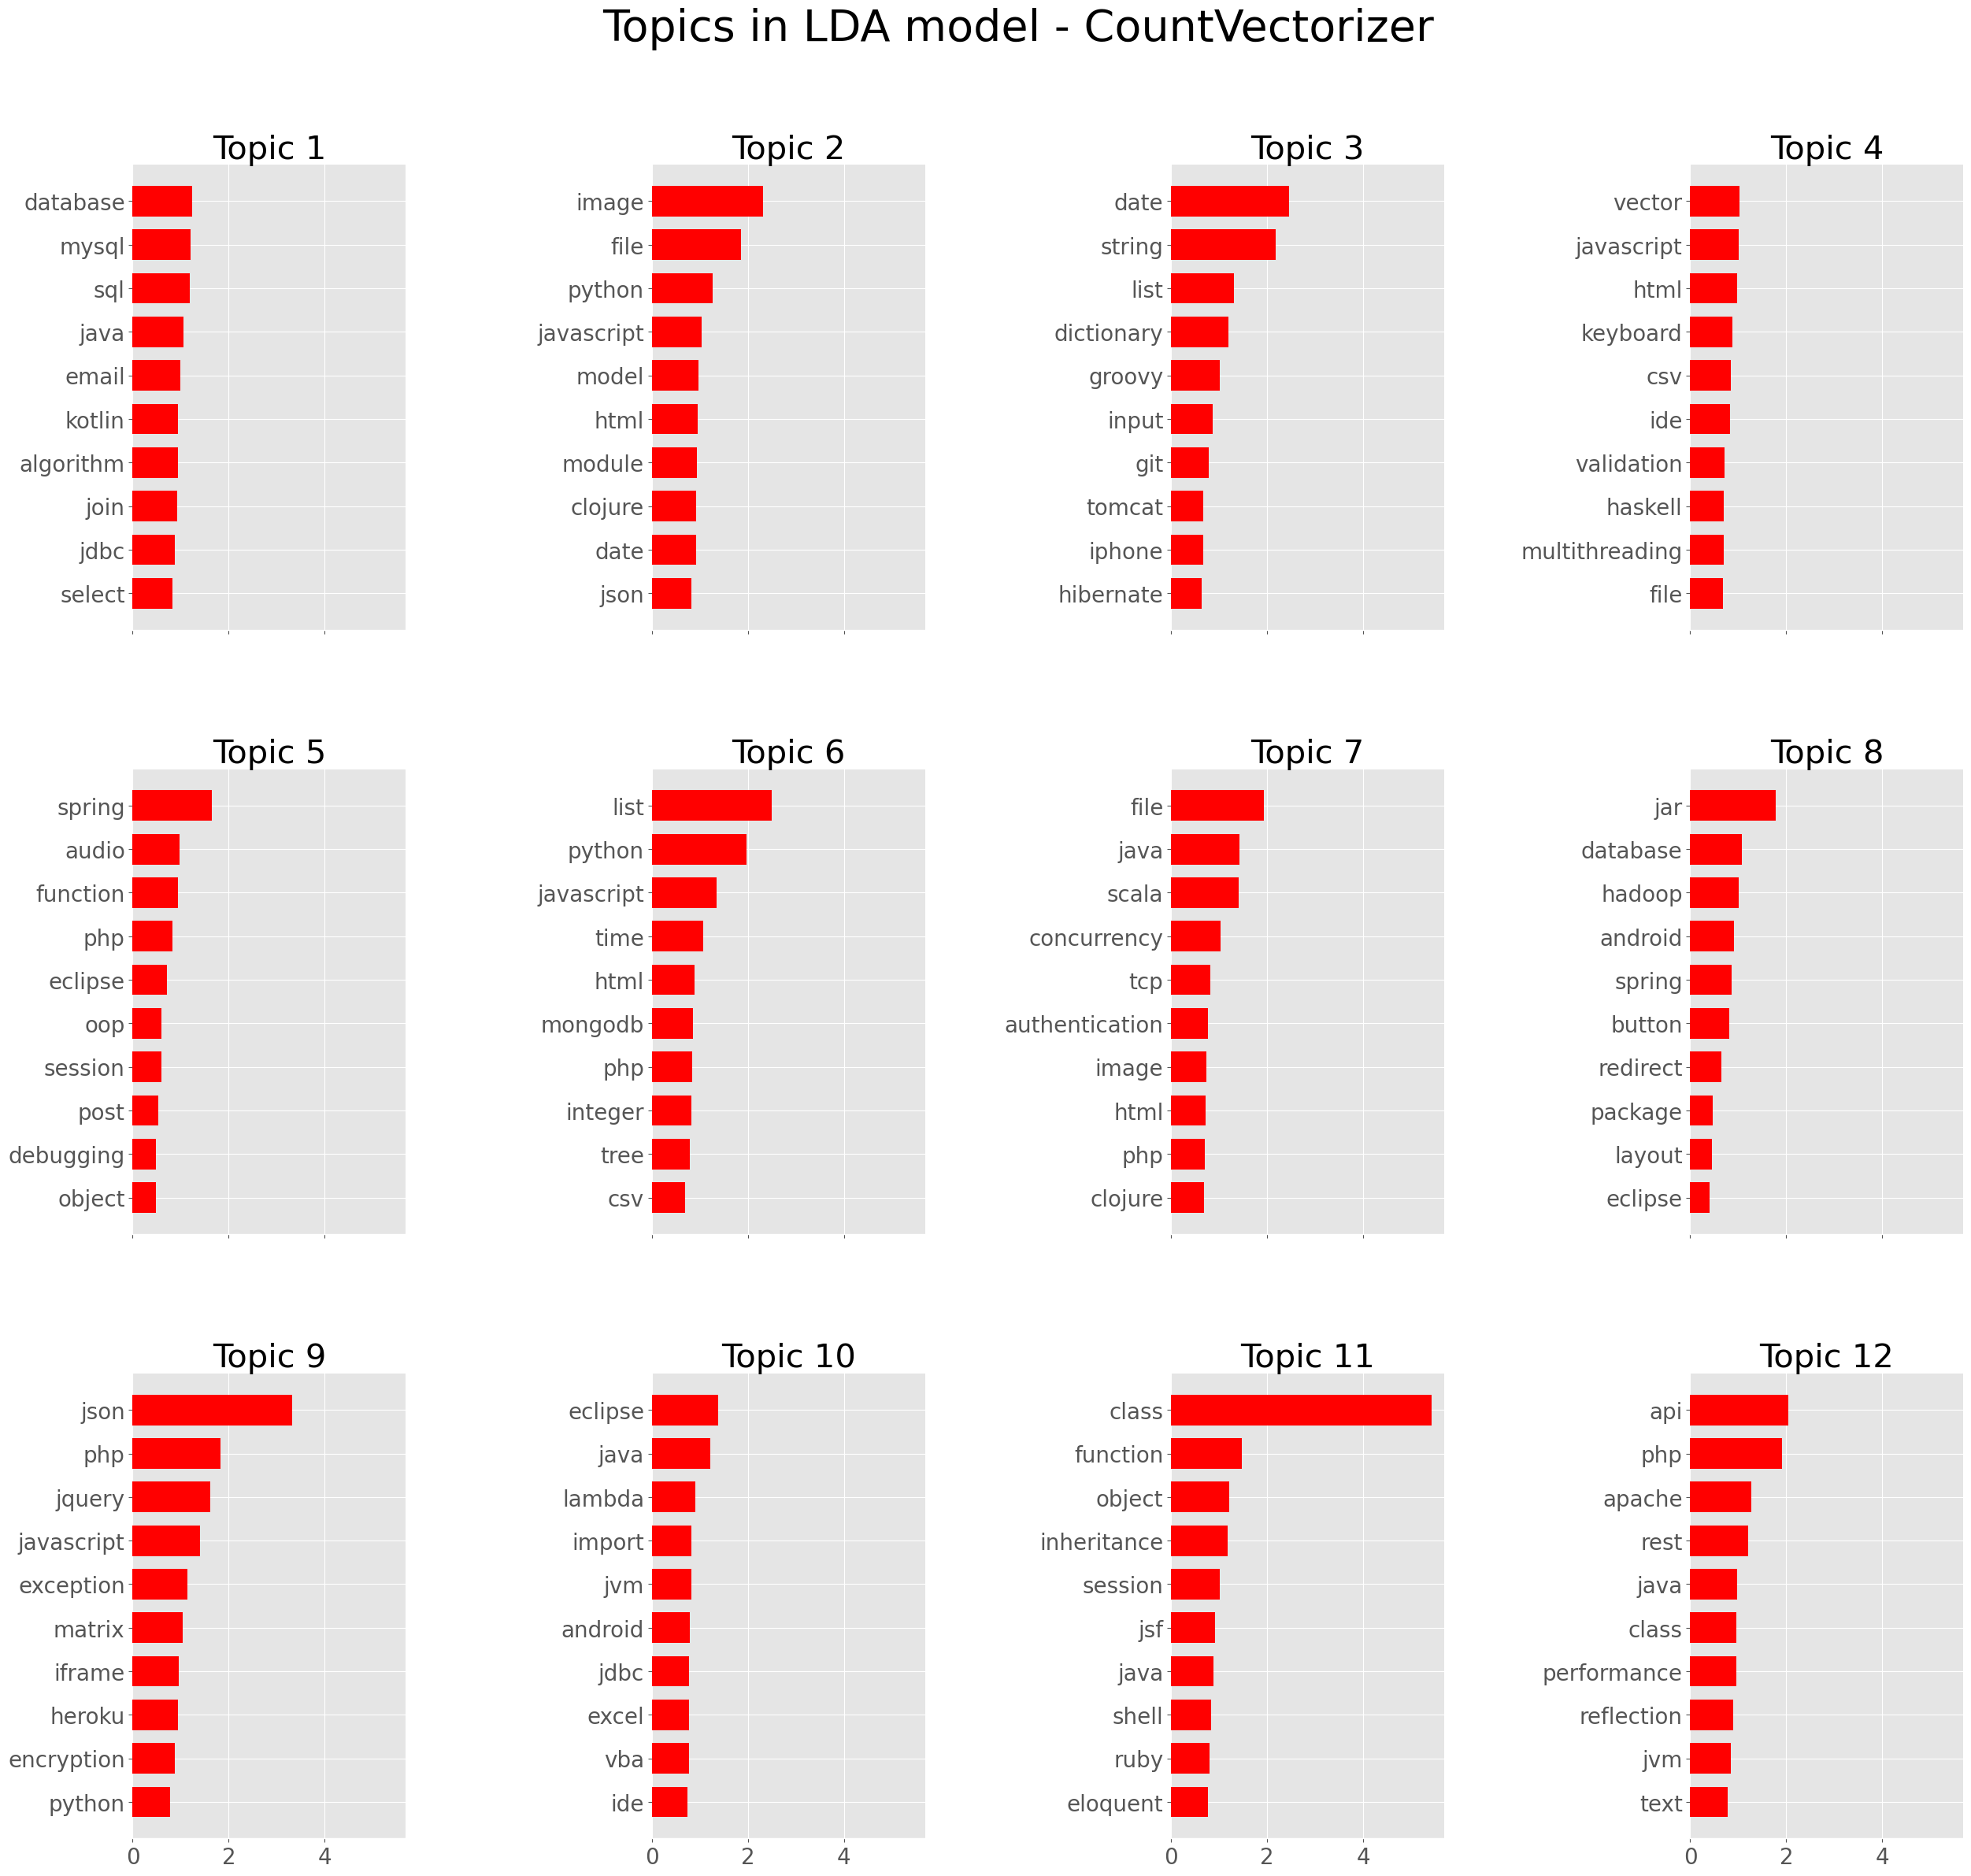

In [28]:
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                random_state=42).fit(tfidf)

plot_top_words(lda, TFIDF_feature_names, n_top_words, 'Topics in LDA model - CountVectorizer', 'red')

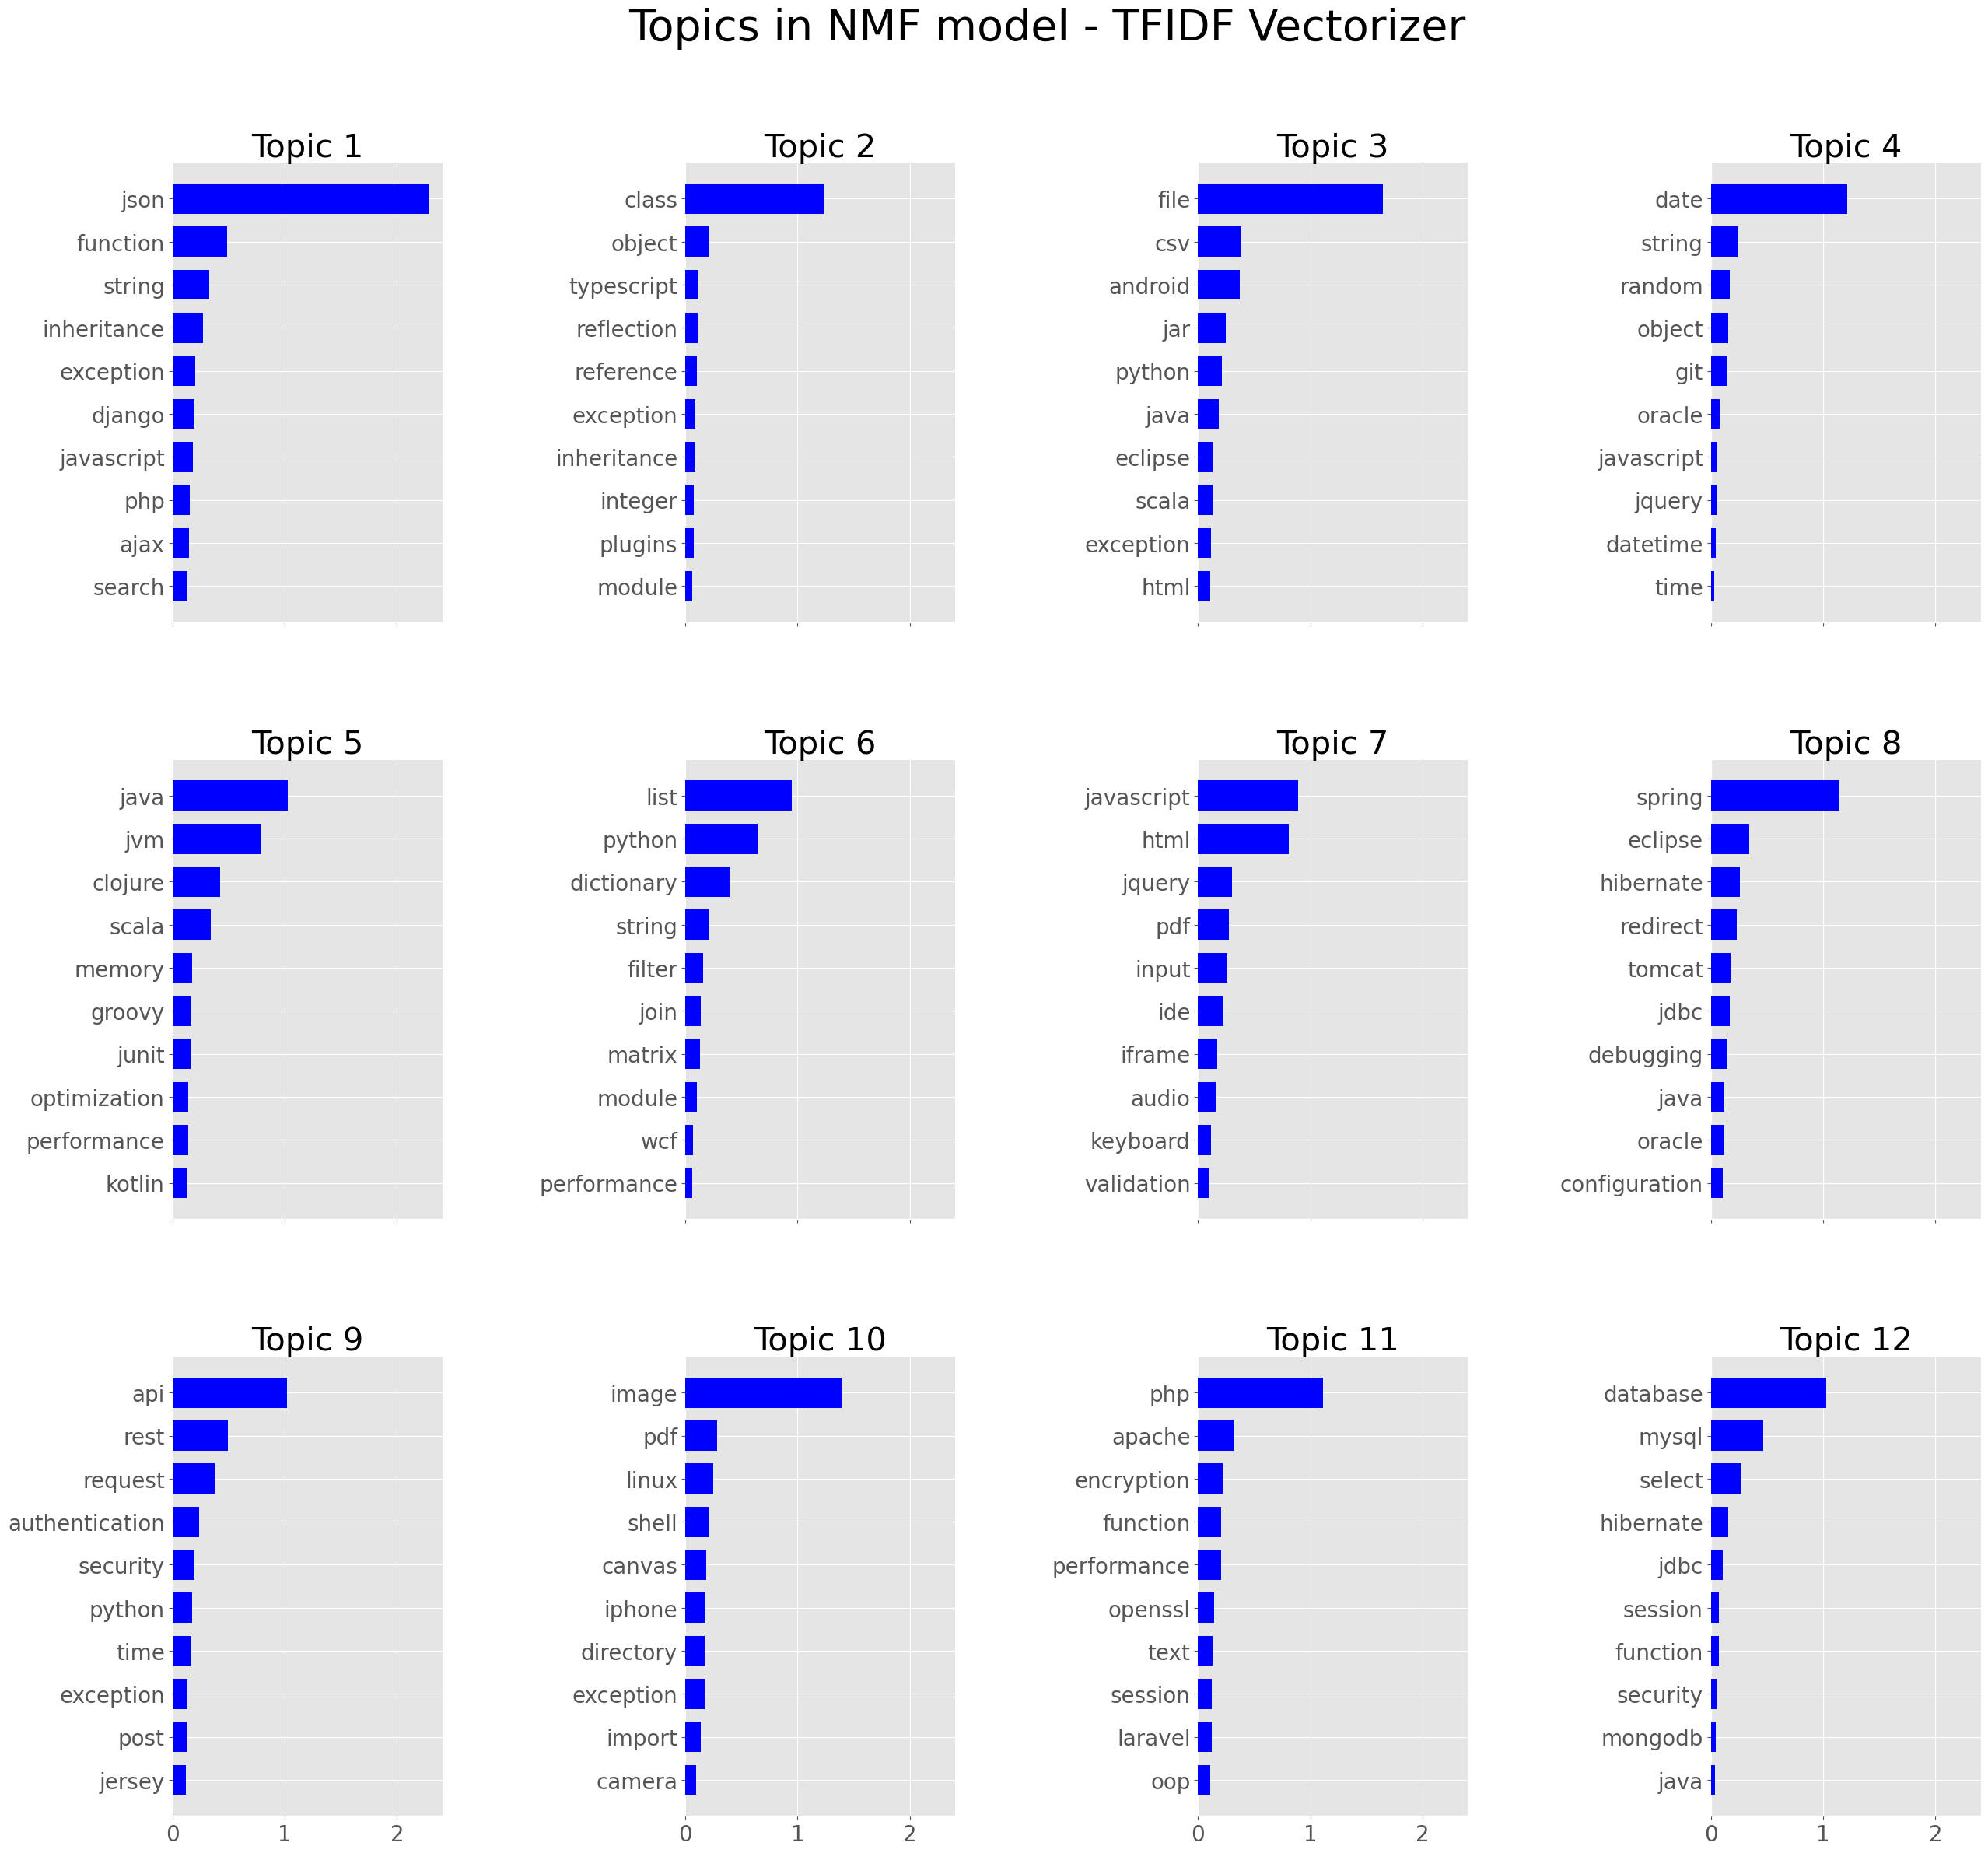

In [29]:
nmf = NMF(n_components=n_topics, random_state=42).fit(tfidf)

plot_top_words(nmf, TFIDF_feature_names, n_top_words,
               'Topics in NMF model - TFIDF Vectorizer', 'blue')

### Visualisation TSNE des topics (2D)

In [30]:
def plot_top_words_tsne(lda_vcv, lda_tfidf, nmf_vcv, nmf_tfidf):
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    axs = axs.ravel()

    # LDA with vcv
    X_embedded = TSNE(n_components=2).fit_transform(lda_vcv)
    axs[0].scatter(X_embedded[:, 0], X_embedded[:, 1], c=lda_vcv.argmax(axis=1))
    axs[0].set_title("LDA with vcv")
    
    # LDA with tfidf
    X_embedded = TSNE(n_components=2).fit_transform(lda_tfidf)
    axs[1].scatter(X_embedded[:, 0], X_embedded[:, 1], c=lda_tfidf.argmax(axis=1))
    axs[1].set_title("LDA with tfidf")
    
    # NMF with vcv
    X_embedded = TSNE(n_components=2).fit_transform(nmf_vcv)
    axs[2].scatter(X_embedded[:, 0], X_embedded[:, 1], c=nmf_vcv.argmax(axis=1))
    axs[2].set_title("NMF with vcv")
    
    # NMF with tfidf
    X_embedded = TSNE(n_components=2).fit_transform(nmf_tfidf)
    axs[3].scatter(X_embedded[:, 0], X_embedded[:, 1], c=nmf_tfidf.argmax(axis=1))
    axs[3].set_title("NMF with tfidf")
    
    plt.show()

In [31]:
lda_vcv = LatentDirichletAllocation(n_components=n_topics, max_iter=5, random_state=42).fit_transform(vcv)
lda_tfidf = LatentDirichletAllocation(n_components=n_topics, max_iter=5, random_state=42).fit_transform(tfidf)
nmf_vcv = NMF(n_components=n_topics, random_state=42).fit_transform(vcv)
nmf_tfidf = NMF(n_components=n_topics, random_state=42).fit_transform(tfidf)

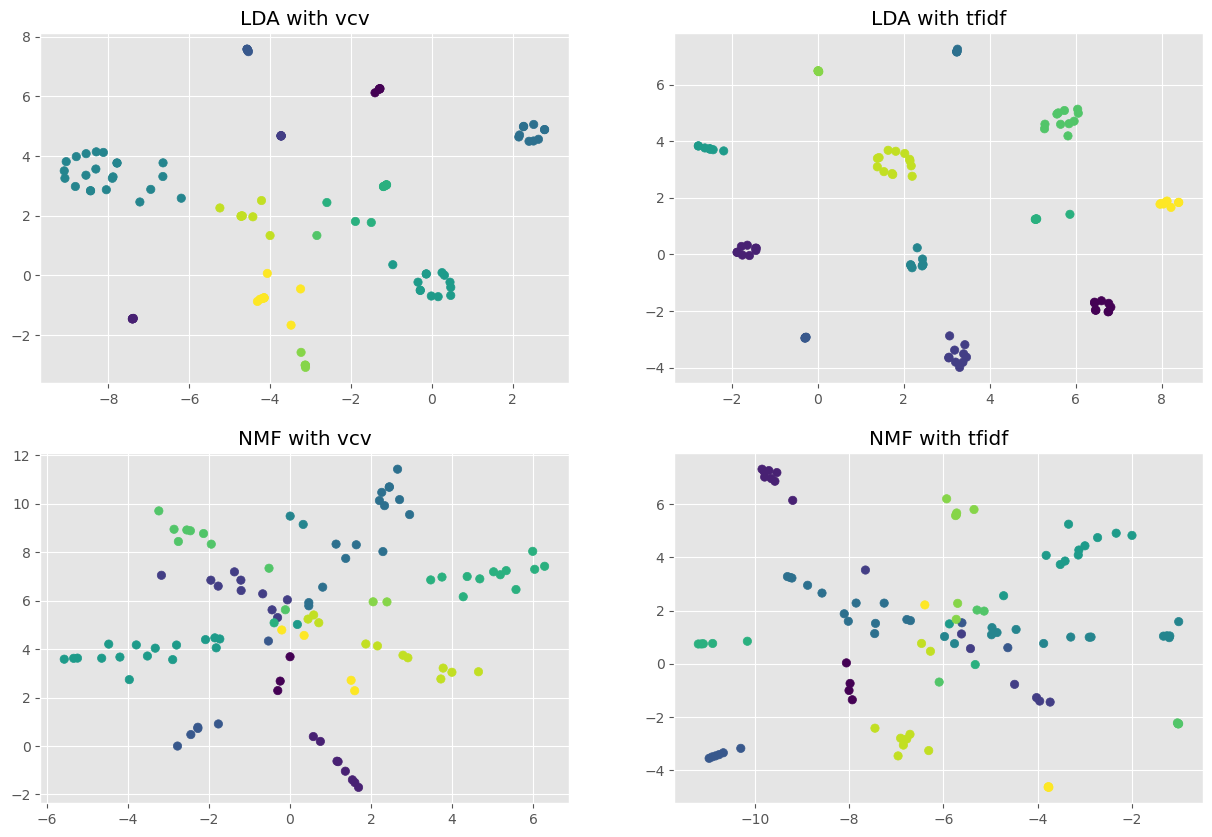

In [32]:
plot_top_words_tsne(lda_vcv, lda_tfidf, nmf_vcv, nmf_tfidf)

### Génération des tags avec LDA et NMF

In [212]:
data_sample["Sentences"][0]

'python json boolean to lowercase string is there a best-practice for outputting booleans in python? i\'m generating some json (via django templates), and by default all the boolean values are output with leading character in uppercase, contrary to the json standard (ie, "true" as opposed to "true"). currently, i format each boolean string using str.lower(), but is there a better way?'

In [213]:
tags_list[0:5]

[['python', 'path', 'directory', 'cross-platform'],
 ['mysql', 'sql', 'database', 'go', 'tdd'],
 ['java', 'xml', 'spring', 'tomcat'],
 ['javascript', 'php', 'laravel', 'session', 'laravel-5'],
 ['firefox', 'ssl', 'https', 'ssl-certificate']]

In [214]:
def get_tags_from_text(texts_list, flat_texts, n_topics):
    pred_tfidf = list()
    pred_cv = list()

    # Predict tags using TF-IDF
    vectorizer = vectorizer_TFIDF
    bow = vectorizer.fit_transform(flat_texts)
    for i in tqdm(range(len(texts_list)), ascii=' >='):
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_tfidf.append(topic_words)

    # Predict tags using CountVectorizer
    vectorizer = vectorizer_CV
    bow = vectorizer.fit_transform(flat_texts)
    for i in tqdm(range(len(texts_list)), ascii=' >='):
        dense_bow_matrix = bow.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
        pred_cv.append(topic_words)

    return pred_tfidf, pred_cv

In [215]:
pred_tfidf, pred_cv = get_tags_from_text(texts_list,
                                         flat_texts,
                                         n_topics)

100%|=============================================================================| 3000/3000 [00:10<00:00, 273.80it/s]


In [216]:
pred_tfidf[0:5]

[['path', 'module', 'directory', 'join', 'linux'],
 ['database', 'sql', 'ffmpeg', 'curl', 'shell'],
 ['xml', 'web', 'http', 'class', 'file'],
 ['session', 'php', 'javascript', 'text', 'function'],
 ['ssl', 'certificate', 'firefox', 'maven', 'encoding']]

In [217]:
pred_cv[0:5]

[['path', 'module', 'directory', 'join', 'python'],
 ['database', 'sql', 'ffmpeg', 'curl', 'shell'],
 ['xml', 'web', 'http', 'file', 'class'],
 ['session', 'php', 'javascript', 'function', 'text'],
 ['ssl', 'certificate', 'firefox', 'maven', 'encoding']]

In [218]:
lda_v = LatentDirichletAllocation(n_components=n_topics, max_iter=5, random_state=42).fit(vcv)
lda_t = LatentDirichletAllocation(n_components=n_topics, max_iter=5, random_state=42).fit(tfidf)
nmf_v = NMF(n_components=n_topics, random_state=42).fit(vcv)
nmf_t = NMF(n_components=n_topics, random_state=42).fit(tfidf)

In [219]:
def get_top_tags(sentences, feature_names, model, vectorizer):
    tags = []
    for i, sentence in tqdm(enumerate(sentences), ascii=' >='):
        sentence_vector = vectorizer.transform([sentence])
        topic_weights = model.transform(sentence_vector)
        top_topics = topic_weights.argmax()
        top_tags = [feature_names[i] for i in model.components_[top_topics].argsort()[:-6:-1]]
        tags.append(top_tags)
    return tags

In [220]:
lda_vcv_tags = get_top_tags(flat_texts, CV_feature_names, lda_v, vectorizer_CV)
lda_vcv_tags[0:5]

3000it [00:04, 671.44it/s]


[['python', 'import', 'module', 'package', 'memory'],
 ['java', 'database', 'mysql', 'session', 'regex'],
 ['file', 'xml', 'xcode', 'path', 'selenium'],
 ['html', 'javascript', 'jquery', 'browser', 'video'],
 ['input', 'certificate', 'http', 'iframe', 'scroll']]

In [221]:
lda_tfidf_tags = get_top_tags(flat_texts, TFIDF_feature_names, lda_t, vectorizer_TFIDF)
lda_tfidf_tags[0:5]

3000it [00:06, 461.83it/s]


[['python', 'module', 'import', 'package', 'memory'],
 ['database', 'java', 'mysql', 'hibernate', 'spring'],
 ['file', 'selenium', 'xml', 'facebook', 'hash'],
 ['database', 'java', 'mysql', 'hibernate', 'spring'],
 ['input', 'button', 'certificate', 'scroll', 'iframe']]

In [222]:
nmf_vcv_tags = get_top_tags(flat_texts, CV_feature_names, nmf_v, vectorizer_CV)
nmf_vcv_tags[0:5]

3000it [00:06, 466.02it/s]


[['python', 'import', 'package', 'module', 'list'],
 ['database', 'mysql', 'jdbc', 'sql', 'php'],
 ['file', 'path', 'csv', 'php', 'html'],
 ['function', 'php', 'javascript', 'html', 'jquery'],
 ['json', 'post', 'request', 'http', 'php']]

In [223]:
nmf_tfidf_tags = get_top_tags(flat_texts, TFIDF_feature_names, nmf_t, vectorizer_TFIDF)
nmf_tfidf_tags[0:5]

3000it [00:08, 339.03it/s]


[['python', 'import', 'module', 'package', 'pip'],
 ['database', 'mysql', 'sql', 'php', 'jdbc'],
 ['class', 'constructor', 'object', 'int', 'function'],
 ['function', 'html', 'javascript', 'jquery', 'input'],
 ['request', 'http', 'post', 'php', 'api']]

### Évaluation des prédictions de tags

 - F1 Score: mesure de l'exactitude d'un modèle, il est un moyen harmonique de précision et de rappel. Il varie de 0 à 1, où un score proche de 1 indique une meilleure performance et un score proche de 0 indique une performance moins bonne. 
 - Jaccard Score: mesure de la similarité entre les deux ensembles de prédictions et de vraies étiquettes. Il varie de 0 à 1, où un score proche de 1 indique une très grande similitude et un score proche de 0 indique une grande dissimilarité.

In [224]:
pred_tags_list = [pred_tfidf, pred_cv, lda_vcv_tags, lda_tfidf_tags, nmf_vcv_tags, nmf_tfidf_tags]
pred_names = ["Tfidf", "CV", "LDA CV", "LDA Tfidf", "NMF CV", "NMF Tfidf"]
pred_tags_bin_list = [mlb.transform(pred_tags) for pred_tags in pred_tags_list]

In [225]:
def evaluate_predictions(true_tags, pred_tags_bin_list, pred_names):
    f1_scores = []
    jaccard_scores = []
    scoring_methods = ["F1 Score", "Jaccard Score"]
    for pred_tags in pred_tags_bin_list:
        f1_scores.append(f1_score(true_tags, pred_tags, average='samples'))
        jaccard_scores.append(jaccard_score(true_tags, pred_tags, average='samples'))

    metrics = {"Jaccard": jaccard_scores, "F1": f1_scores}
    metrics_df = pd.DataFrame(metrics, index=pred_names)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    axes = axes.ravel()
    for i, metric in enumerate(metrics.keys()):
        sns.barplot(data=metrics_df, x=metrics_df.index, y=metric, ax=axes[i])
        axes[i].set_ylabel('Score')
        axes[i].set_title(scoring_methods[i])
    plt.show()
    return metrics_df.T

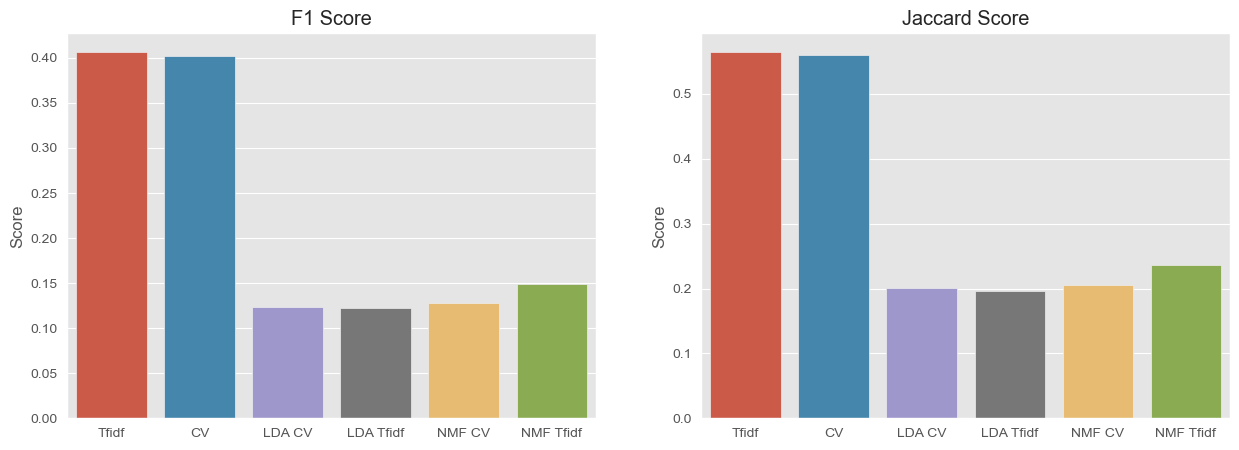

,Tfidf,CV,LDA CV,LDA Tfidf,NMF CV,NMF Tfidf
Jaccard,0.406871,0.401800,0.123393,0.122745,0.127802,0.148882
F1,0.565178,0.559978,0.200274,0.196956,0.206052,0.236719


In [226]:
evaluate_predictions(tags_mlb, pred_tags_bin_list, pred_names)

Nous observons de meilleurs scores avec simplement un vectorizer.

In [227]:
def jaccard_index(list1, list2):
    s1 = set(list1)
    s2 = set(list2)
    if not s1 and not s2:
        return 0
    return len(s1 & s2) / len(s1 | s2)


def calculate_scores(true_tags, pred_tags):
    scores = [jaccard_index(t, p) for t, p in zip(true_tags, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score


def jaccard_index_mod(list1, list2):
    """ 
    Fonction jaccard_index modifiée
    La division ne se fait pas sur l'union des deux sets
    mais par le nombre de tags prédits (list2)
    afin de ne pas pénaliser les scores des observations
    avec moins de 5 tags
    """
    s1 = set(list1)
    s2 = set(list2)
    if not s1 or not s2:
        return 0
    return len(s1 & s2) / min(len(s1),len(s2))


def calculate_scores_mod(tags_list, pred_tags):
    scores = [jaccard_index_mod(t, p) for t, p in zip(tags_list, pred_tags)]
    mean_score = sum(scores) / len(scores)
    return mean_score


def plot_similar_tags(tags_list, pred_tags, method):
    
    mean_score = calculate_scores(tags_list, pred_tags)
    mean_score_mod = calculate_scores_mod(tags_list, pred_tags)
    similar_counts = []
    for pred_tags, tags_list in zip(pred_tags, tags_list):
        similar_words = set(pred_tags) & set(tags_list)
        similar_counts.append(len(similar_words))

    counter = Counter(similar_counts)
    counter = dict(sorted(counter.items()))

    keys = set(range(0, 6))
    missing_keys = keys - set(counter.keys())
    for key in missing_keys:
        counter[key] = 0
    sorted_counter = dict(sorted(counter.items()))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(f"Similarité des tags avec la méthode {method}", fontsize=14,
                 fontweight='bold', y=1.05)
    axs[0].bar(sorted_counter.keys(), sorted_counter.values())
    axs[0].set_xticks(range(0, 6, 1))
    axs[0].set_xticklabels(sorted_counter.keys(), rotation=0)
    axs[0].set_xlabel('Nombre de tags similaires', fontsize=11)
    axs[0].set_ylabel("Nombre d'observations", fontsize=11)
    axs[0].set_title("Nombre d'observations avec un\n"
                     "nombre de tags similaires", fontsize=12)
    axs[1].pie(sorted_counter.values(), labels=sorted_counter.keys(),
               autopct='%1.1f%%', pctdistance=0.8)
    axs[1].legend(title='Tags\nSimilaires', bbox_to_anchor=(1, 0.9), prop={'size': 8},
                 title_fontsize=10)
    axs[1].set_title("Pourcentage d'observations avec \n"
                     "un nombre de tags similaires", fontsize=12)

    textstr = f'Jaccard_index = {mean_score:.2f}\nJaccard_index_mod = {mean_score_mod:.2f}'
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    axs[1].text(0.8, 0, textstr, transform=axs[1].transAxes, fontsize=12,
                verticalalignment='top', bbox=props)

    plt.show()

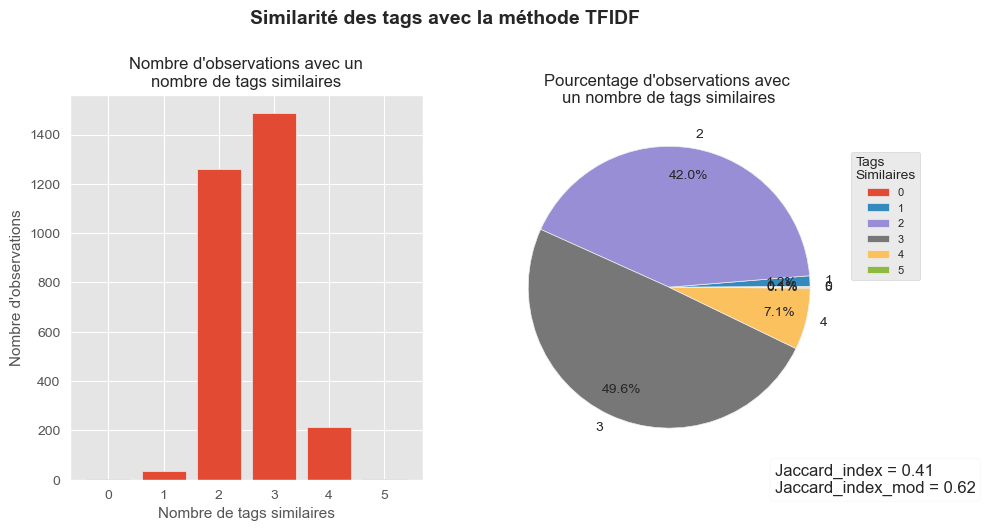

In [228]:
plot_similar_tags(tags_list, pred_tfidf, 'TFIDF')

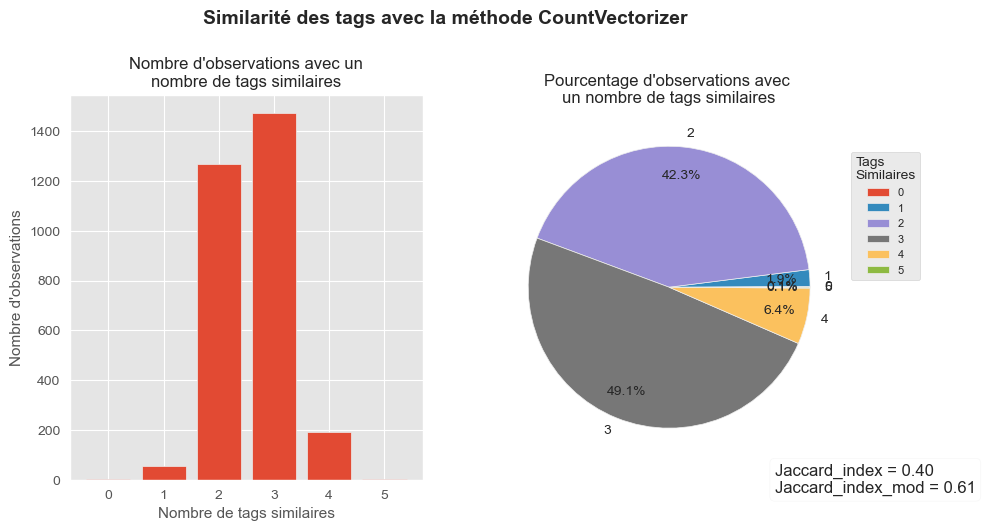

In [229]:
plot_similar_tags(tags_list, pred_cv, 'CountVectorizer')

Les modèles avec CountVectorizer et TfidfVectorizer prédisent des tags assez similaires à ceux donnés par les utilisateurs.

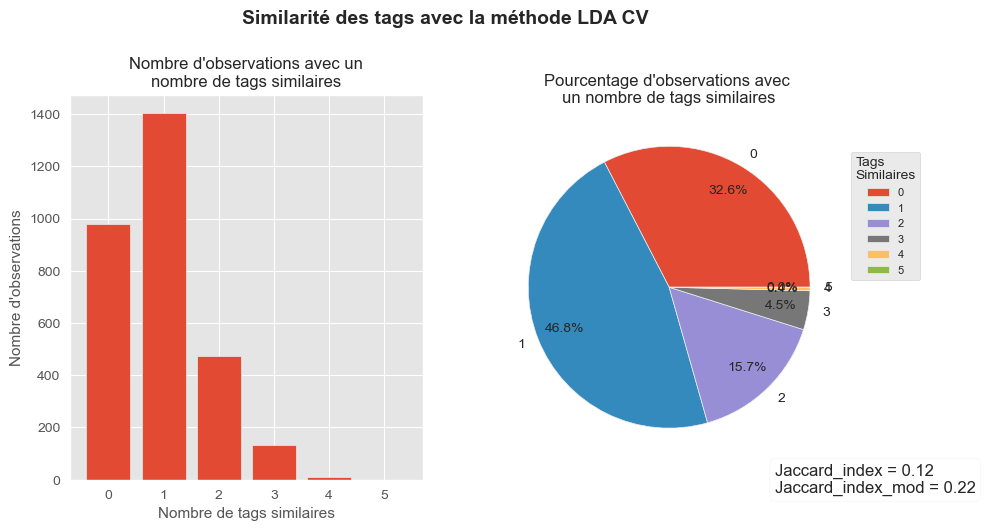

In [230]:
plot_similar_tags(tags_list, lda_vcv_tags, 'LDA CV')

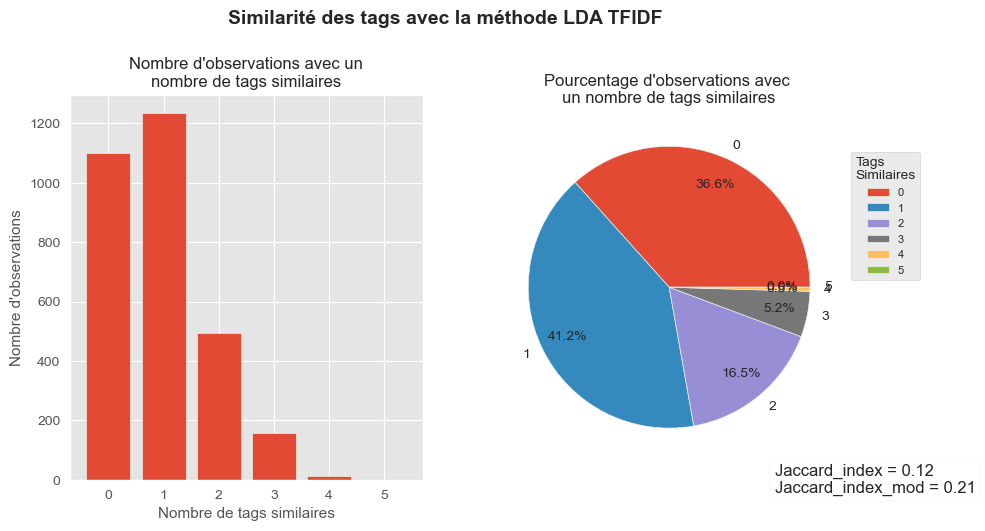

In [231]:
plot_similar_tags(tags_list, lda_tfidf_tags, 'LDA TFIDF')

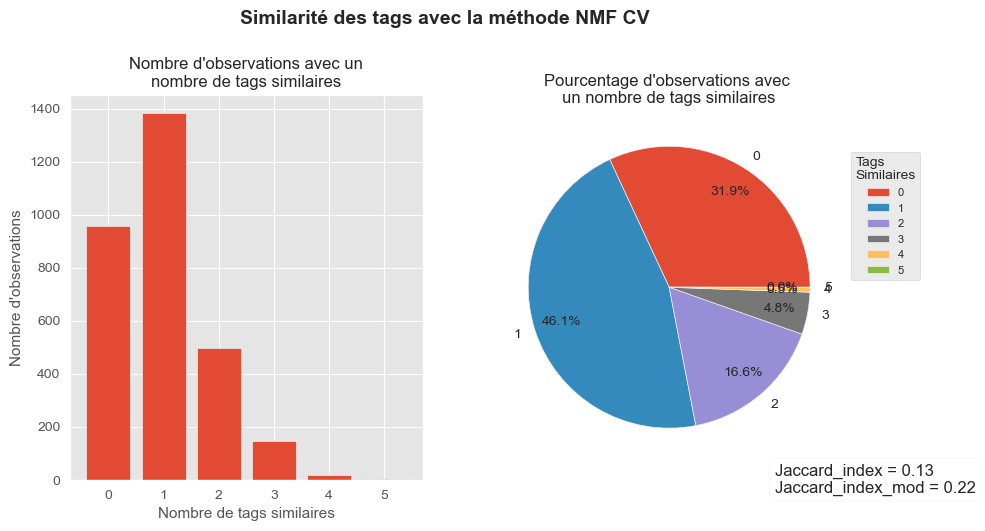

In [232]:
plot_similar_tags(tags_list, nmf_vcv_tags, 'NMF CV')

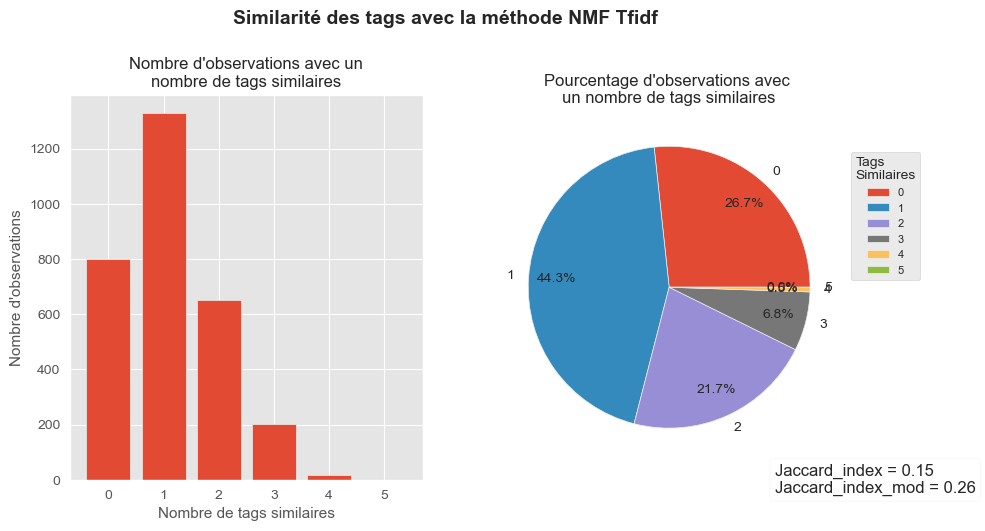

In [233]:
plot_similar_tags(tags_list, nmf_tfidf_tags, 'NMF Tfidf')

## <font color="#114b98" id="section_3">3. Approche non supervisée : RAKE</font>

In [234]:
from rake_nltk import Rake

In [235]:
def extract_keywords(input_text, new_sentences):
    all_keywords = []
    text = input_text + new_sentences
    # Encode all the sentences in the input text
    for i in tqdm(range(len(text)), ascii=' >='):
        # Extract the keywords from the new sentence using RAKE
        keyword_extractor = Rake()
        keyword_extractor.extract_keywords_from_text(text[i])
        word_degrees = keyword_extractor.get_word_degrees()
        sorted_word_degrees = sorted(word_degrees.items(), key=lambda x: x[1], reverse=True)
        keywords = [word for word, degree in sorted_word_degrees[:5]]
        all_keywords.append(keywords)
    return all_keywords[-len(new_sentences):]

In [236]:
rake_keywords = extract_keywords(flat_texts, flat_texts_eval)

100%|=============================================================================| 6000/6000 [00:08<00:00, 686.93it/s]


In [237]:
rake_keywords[0:5]

[['image', 'python', 'matlab', 'search', 'opengl'],
 ['date', 'mysql'],
 ['time', 'date', 'php'],
 ['interface', 'inheritance'],
 ['http', 'post', 'jquery', 'security', 'url']]

In [238]:
tags_list_eval[0:5]

[['python', 'c', 'image', 'matlab'],
 ['php', 'mysql', 'unix', 'date', 'time'],
 ['php', 'string', 'date', 'time'],
 ['c#', 'oop', 'inheritance', 'interface'],
 ['javascript', 'jquery', 'security', 'post', 'ssl']]

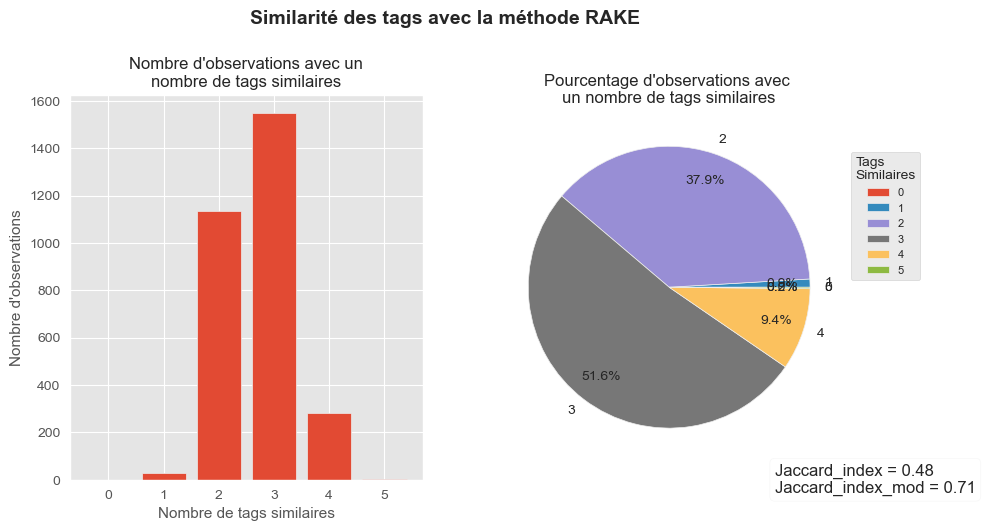

In [239]:
plot_similar_tags(tags_list_eval, rake_keywords, 'RAKE')

## <font color="#114b98" id="section_4">4. Approche supervisée : Classifiers</font>

### Étude avec 5 classificateurs sklearn

In [240]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

In [241]:
classifiers = [LogisticRegression(random_state=42, max_iter=300, tol=1e-5),
               SGDClassifier(random_state=42, max_iter=300, tol=1e-5),
#                RandomForestClassifier(random_state=42),
               KNeighborsClassifier(),
               MultinomialNB()]

In [242]:
def calculate_supervised_scores_(flat_texts, tags_mlb, vectorizer, classifiers):

    # Create an empty dataframe to store the results
    results_df = pd.DataFrame(columns=['Classifier',
                                       'F1 Score',
                                       'Jaccard Score'])

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)

    # Vectorize X_train and X_test
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    # Fit an independent model for each class using the OneVsRestClassifier wrapper.
    for classifier in tqdm(classifiers, ascii=' >='):
        ovrc = OneVsRestClassifier(classifier)
        ovrc.fit(X_train, y_train)
        y_pred_ovrc = ovrc.predict(X_test)

        f1 = round(f1_score(y_test, y_pred_ovrc, average='samples'), 4)
        jaccard = round(jaccard_score(y_test, y_pred_ovrc, average='samples'), 4)

        results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                        'F1 Score': f1,
                                        'Jaccard Score': jaccard},
                                        ignore_index=True)

    return results_df

In [243]:
results_CountVectorizer = calculate_supervised_scores_(flat_texts,
                                                       tags_mlb,
                                                       vectorizer_CV,
                                                       classifiers)
results_CountVectorizer

100%|====================================================================================| 4/4 [01:02<00:00, 15.51s/it]


,Classifier,F1 Score,Jaccard Score
0,LogisticRegression,0.5587,0.4207
1,SGDClassifier,0.5500,0.4056
2,KNeighborsClassifier,0.3858,0.2695
3,MultinomialNB,0.4018,0.2704


In [244]:
def plot_results(results_df):
    
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # Set a color palette
    my_palette = sns.color_palette("husl", 5)

    # Set the x-axis to be a range of numerical values
    x = range(len(results_df))
    scoring_methods = ['F1 Score', 'Jaccard Score']

    # Create a subplot for each scoring method
    for i, scoring_method in enumerate(scoring_methods):
        sns.barplot(x='Classifier', 
                    y=scoring_method, 
                    data=results_df, 
                    ax=axs[i], 
                    palette=my_palette, 
                    label=scoring_method)

    # Add classifier names to x-axis
    for i in range(2):
        axs[i].set_title(scoring_methods[i])
        axs[i].set_xticks(x)
        axs[i].set_xlabel('')
        axs[i].set_ylabel('Score')
        axs[i].set_xticklabels(results_df['Classifier'], rotation=90)

    plt.show()

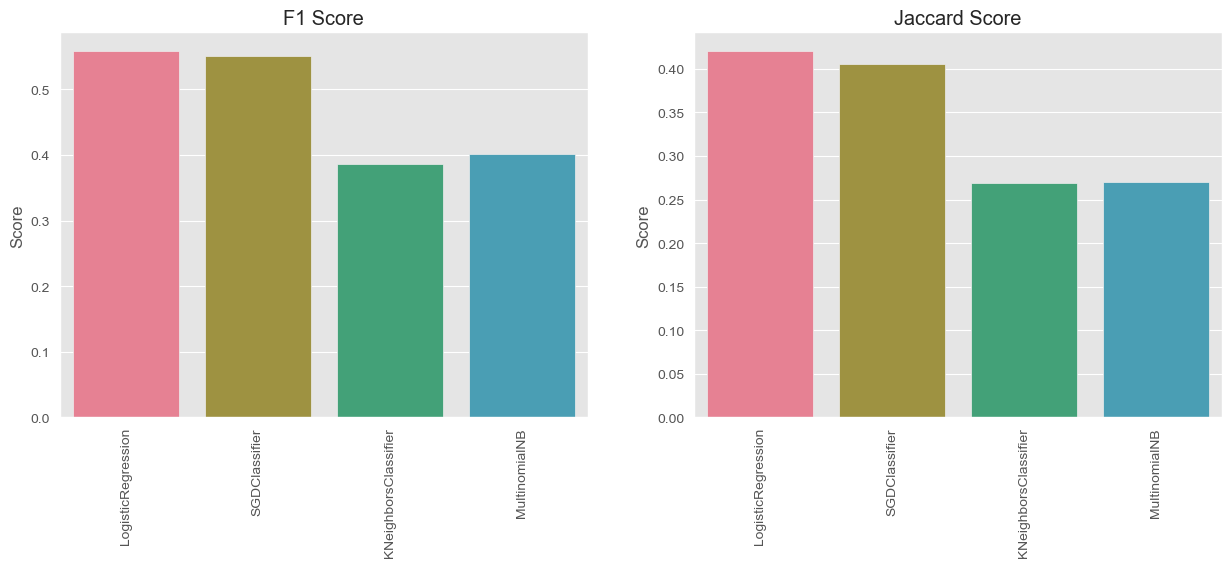

In [245]:
plot_results(results_CountVectorizer)

In [246]:
results_TfidfVectorizer = calculate_supervised_scores_(flat_texts,
                                                       tags_mlb,
                                                       vectorizer_TFIDF,
                                                       classifiers)
results_TfidfVectorizer

100%|====================================================================================| 4/4 [00:46<00:00, 11.52s/it]


,Classifier,F1 Score,Jaccard Score
0,LogisticRegression,0.3810,0.2684
1,SGDClassifier,0.6354,0.4924
2,KNeighborsClassifier,0.4433,0.3132
3,MultinomialNB,0.2157,0.1437


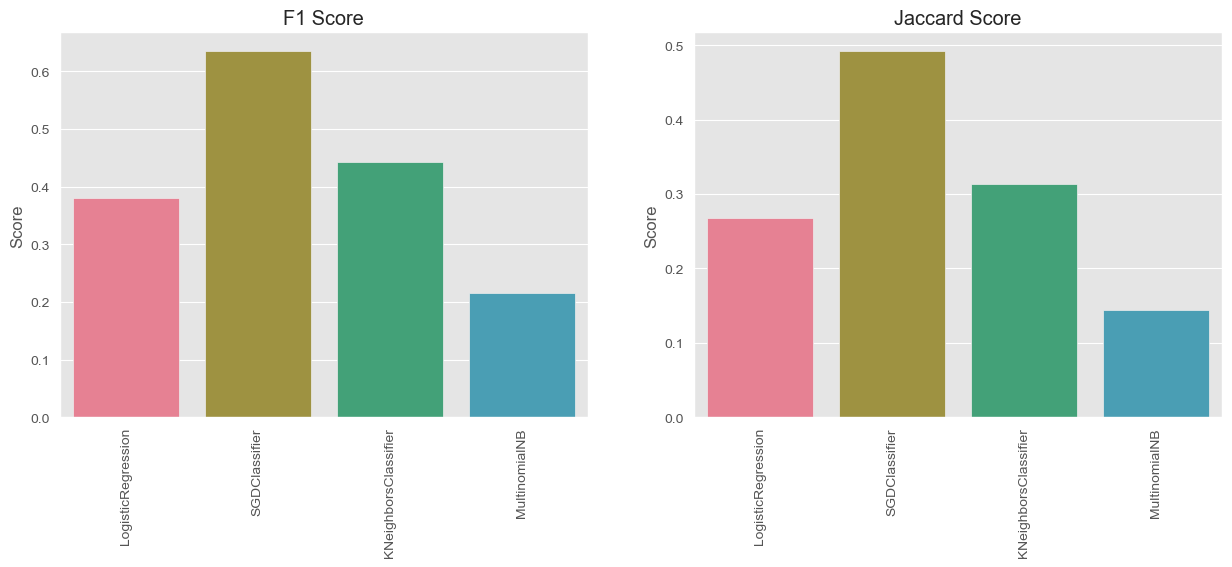

In [247]:
plot_results(results_TfidfVectorizer)

Le SGDClassifier obtient les meilleurs scores, peu importe le vectorizer utilisé.

Le classificateur LogisticRegression semble assez performant avec CountVectorizer.

### LogisticRegression + GridSearchCV

In [248]:
results_LR = pd.DataFrame(columns=['F1 Score', 'Jaccard Score'])
results_LR = results_LR.append(results_CountVectorizer.iloc[0, 1:]).reset_index(drop=True)
results_LR = results_LR.append(results_TfidfVectorizer.iloc[0, 1:]).reset_index(drop=True)
results_LR['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_LR

,F1 Score,Jaccard Score,Classifier
0,0.5587,0.4207,CountVectorizer
1,0.3810,0.2684,TfidfVectorizer


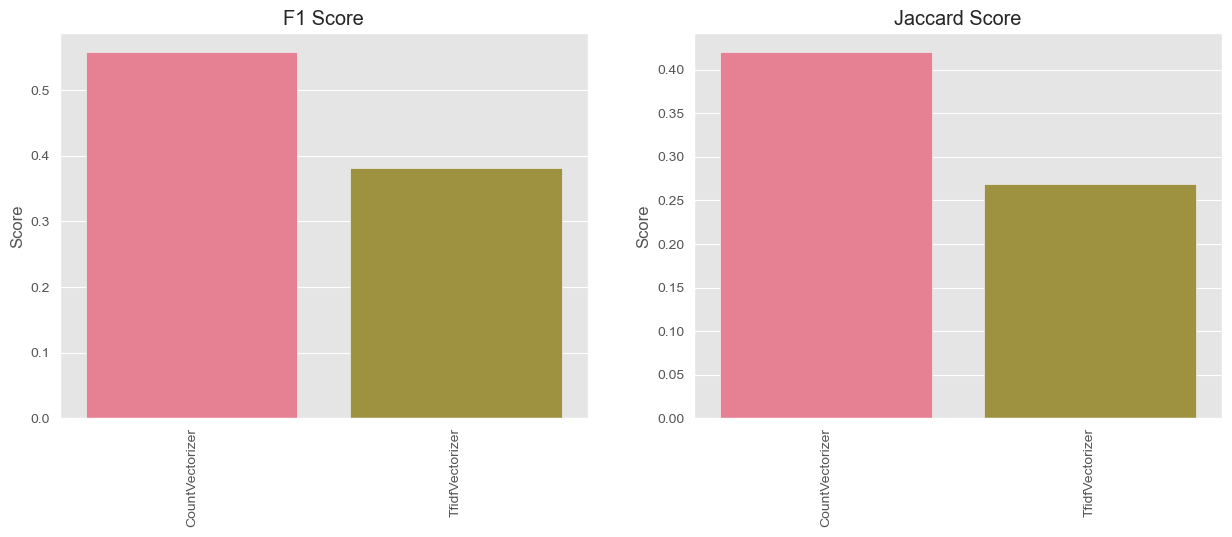

In [249]:
plot_results(results_LR)

CountVectorizer permet d'avoir des performances largement supérieures à TF-IDF.

In [250]:
classifier_LR = LogisticRegression(random_state=42, max_iter=300, tol=1e-5)

parameters_LR = {'estimator__C': [0.01, 0.1, 0.01],
#                  'estimator__penalty': ['l1', 'l2'],
#                  'estimator__solver': ['lbfgs', 'liblinear']
                }

In [251]:
def calculate_supervised_scores(flat_texts, tags_mlb, vectorizer, classifier, parameters):
    results_df = pd.DataFrame(columns=['Classifier', 'F1 Score', 'Jaccard Score'])
    X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    
    ovrc = OneVsRestClassifier(classifier)
    clf = GridSearchCV(ovrc, parameters, cv=5, verbose=1)
    
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    best_params = clf.best_params_ if hasattr(clf, 'best_params_') else None
    
    f1 = round(f1_score(y_test, y_pred, average='samples'), 4)
    jaccard = round(jaccard_score(y_test, y_pred, average='samples'), 4)
    
    results_df = results_df.append({'Classifier': str(classifier).split('(')[0], 
                                    'F1 Score': f1,
                                    'Jaccard Score': jaccard},
                                    ignore_index=True)
    return results_df, best_params

In [252]:
results_LR, best_params_LR = calculate_supervised_scores(flat_texts,
                                                         tags_mlb,
                                                         vectorizer_CV,
                                                         classifier_LR,
                                                         parameters_LR)
results_LR

Fitting 5 folds for each of 3 candidates, totalling 15 fits


,Classifier,F1 Score,Jaccard Score
0,LogisticRegression,0.4281,0.3111


Ce modèle est légèrement amélioré mais il reste toujours très inférieur au modèle non hyperparamétré avec SGDClassifier.

In [253]:
params_LR = {key.replace('estimator__', ''): value for key, value in best_params_LR.items()}

classifier = LogisticRegression(random_state=42, max_iter=300, tol=1e-5, **params_LR)

ovrc_LR = OneVsRestClassifier(classifier)

X_train, X_test, y_train, y_test = train_test_split(flat_texts,
                                                    tags_mlb,
                                                    test_size=0.2,
                                                    random_state=42)
X_train = vectorizer_CV.fit_transform(X_train)
ovrc_LR.fit(X_train, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=0.1, max_iter=300,
                                                 random_state=42, tol=1e-05))

In [254]:
X_test_ = vectorizer_CV.transform(X_test)
y_pred_LR = ovrc_LR.predict(X_test_)

tags_LR = mlb.inverse_transform(y_pred_LR)
tags_LR[0:5]

[('java', 'jar'),
 ('image', 'android'),
 ('java', 'jdbc'),
 ('json',),
 ('image', 'vector')]

In [255]:
count = 0
for i in tags_LR:
    if len(i) >= 3:
        count += 1

print("The number of tuples with 3 or more words in the list is:", count)

The number of tuples with 3 or more words in the list is: 150


In [256]:
true_tags_lr = mlb.inverse_transform(y_test)
true_tags_lr[0:5]

[('java', 'jar', 'algorithm', 'search', 'performance'),
 ('email', 'image', 'bitmap', 'android'),
 ('java', 'database', 'mysql', 'jdbc'),
 ('java', 'jackson', 'jersey', 'rest'),
 ('pdf', 'java', 'image', 'vector')]

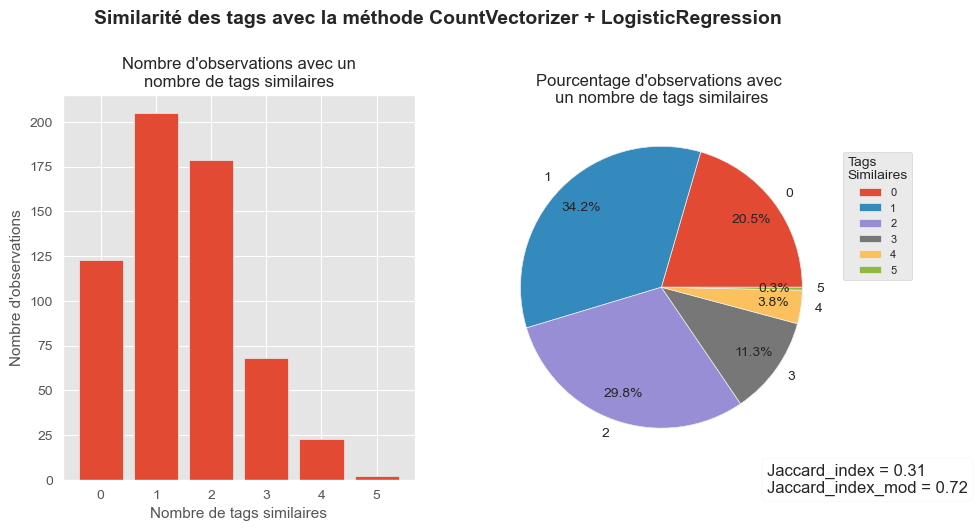

In [257]:
plot_similar_tags(true_tags_lr, tags_LR, 'CountVectorizer + LogisticRegression')

### SGDClassifier + GridSearchCV

In [258]:
results_SGD = pd.DataFrame(columns=['F1 Score', 'Jaccard Score'])
results_SGD = results_SGD.append(results_CountVectorizer.iloc[1, 1:]).reset_index(drop=True)
results_SGD = results_SGD.append(results_TfidfVectorizer.iloc[1, 1:]).reset_index(drop=True)
results_SGD['Classifier'] = ['CountVectorizer', 'TfidfVectorizer']
results_SGD

,F1 Score,Jaccard Score,Classifier
0,0.5500,0.4056,CountVectorizer
1,0.6354,0.4924,TfidfVectorizer


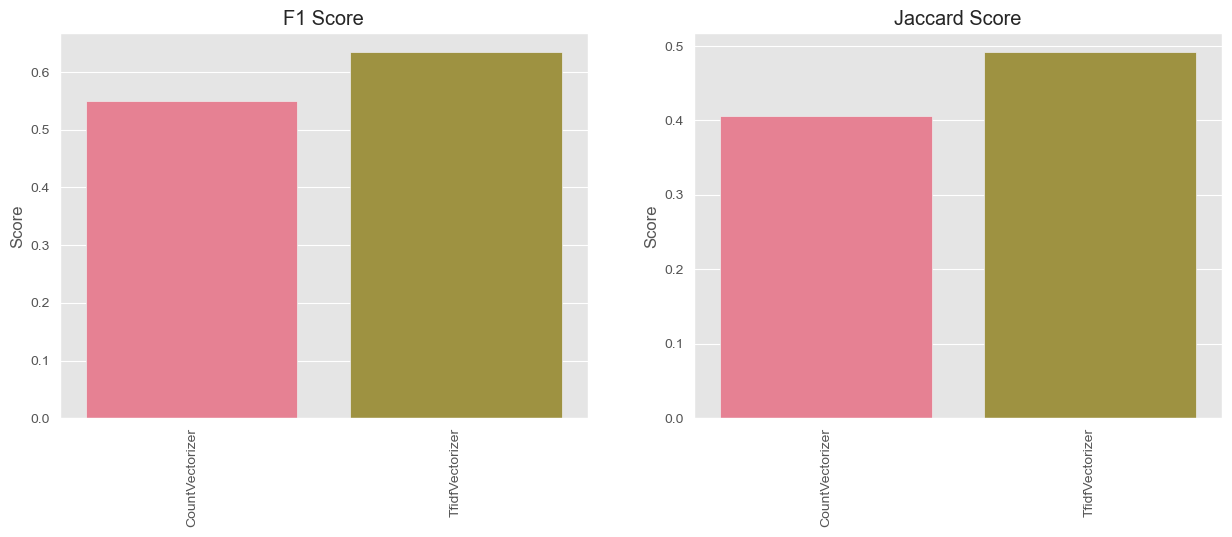

In [259]:
plot_results(results_SGD)

CountVectorizer permet d'avoir des performances légèrement supérieures à TF-IDF.

estimator__alpha: This is the regularization strength. Increasing the value of alpha will make the model more conservative, resulting in fewer non-zero coefficients and therefore fewer keywords.

estimator__loss: This is the loss function to be optimized. The 'hinge' loss function may lead to more sparsity than 'log' or 'modified_huber'. Therefore, you may want to try switching to one of these loss functions.

estimator__penalty: This parameter specifies the regularization term to be used. The 'l1' penalty will result in more sparsity than 'l2'. Therefore, you could try using 'l1' regularization.

Therefore, if you increase the regularization strength in the SGDClassifier or use L1 regularization instead of L2, the resulting model may have more zero coefficients, which means more sparsity.

In [260]:
classifier_SGD = SGDClassifier(random_state=42)

parameters_SGD = {'estimator__alpha': [0.01, 0.1, 1],
                  'estimator__loss': ['log', 'modified_huber'], #hinge
                  'estimator__penalty': ['l2']} #l1

In [261]:
results_SGD, best_params_SGD = calculate_supervised_scores(flat_texts,
                                                           tags_mlb,
                                                           vectorizer_CV,
                                                           classifier_SGD,
                                                           parameters_SGD)
results_SGD

Fitting 5 folds for each of 6 candidates, totalling 30 fits


,Classifier,F1 Score,Jaccard Score
0,SGDClassifier,0.5838,0.4405


In [262]:
best_params_SGD

{'estimator__alpha': 0.01,
 'estimator__loss': 'modified_huber',
 'estimator__penalty': 'l2'}

In [263]:
results_CountVectorizer[results_CountVectorizer['Classifier']=='SGDClassifier']

,Classifier,F1 Score,Jaccard Score
1,SGDClassifier,0.55,0.4056


In [264]:
results_CV = pd.concat([results_CountVectorizer[results_CountVectorizer['Classifier']=='SGDClassifier'],
                        results_SGD])
results_CV.iloc[1,0] = 'SGDClassifier_CV'
results_CV

,Classifier,F1 Score,Jaccard Score
1,SGDClassifier,0.5500,0.4056
0,SGDClassifier_CV,0.5838,0.4405


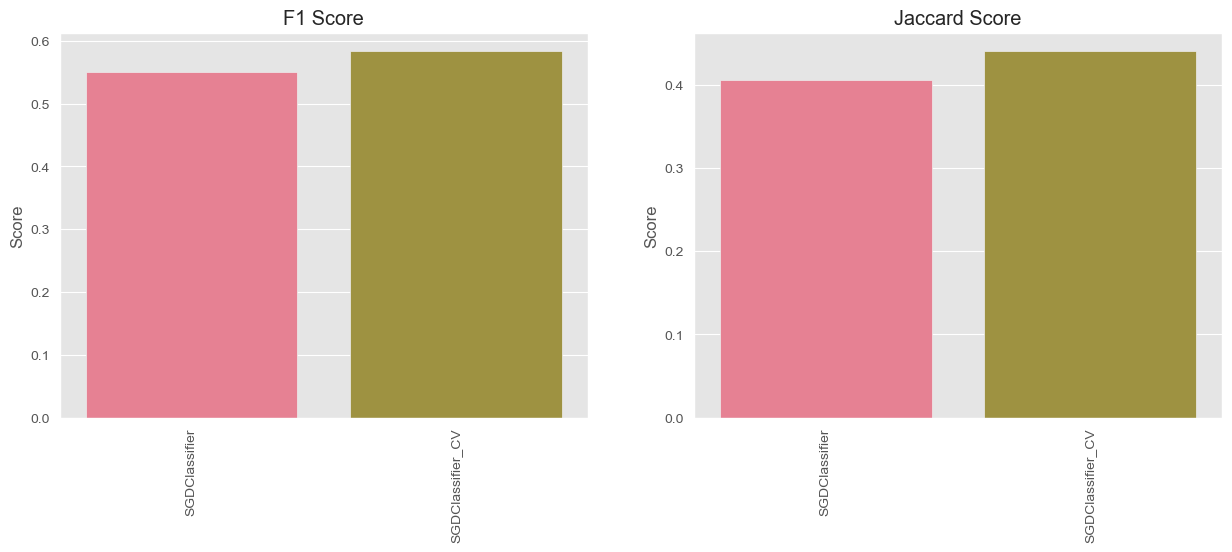

In [265]:
# Call the plot_results function
plot_results(results_CV)

Le modèle a bien pu être amélioré par Cross-Validation.

In [266]:
params_SGDC = {key.replace('estimator__', ''): value for key, value in best_params_SGD.items()}

classifier = SGDClassifier(random_state=42, **params_SGDC)

ovrc_SGDC = OneVsRestClassifier(classifier)

X_train, X_test, y_train, y_test = train_test_split(flat_texts,
                                                    tags_mlb,
                                                    test_size=0.2,
                                                    random_state=42)
X_train = vectorizer_CV.fit_transform(X_train)
ovrc_SGDC.fit(X_train, y_train)

OneVsRestClassifier(estimator=SGDClassifier(alpha=0.01, loss='modified_huber',
                                            random_state=42))

In [267]:
X_test_ = vectorizer_CV.transform(X_test)
y_pred_SGDC = ovrc_SGDC.predict(X_test_)

tags_SGDC = mlb.inverse_transform(y_pred_SGDC)
tags_SGDC[0:5]

[('class', 'java', 'jar'),
 ('image', 'bitmap', 'android'),
 ('sql', 'java', 'database', 'jdbc'),
 ('java', 'jackson', 'json', 'database', 'jersey'),
 ('image', 'vector')]

In [268]:
count = 0
for i in tags_SGDC:
    if len(i) >= 3:
        count += 1

print("The number of tuples with 3 or more words in the list is:", count)

The number of tuples with 3 or more words in the list is: 324


In [269]:
true_tags_sgd = mlb.inverse_transform(y_test)
true_tags_sgd[0:5]

[('java', 'jar', 'algorithm', 'search', 'performance'),
 ('email', 'image', 'bitmap', 'android'),
 ('java', 'database', 'mysql', 'jdbc'),
 ('java', 'jackson', 'jersey', 'rest'),
 ('pdf', 'java', 'image', 'vector')]

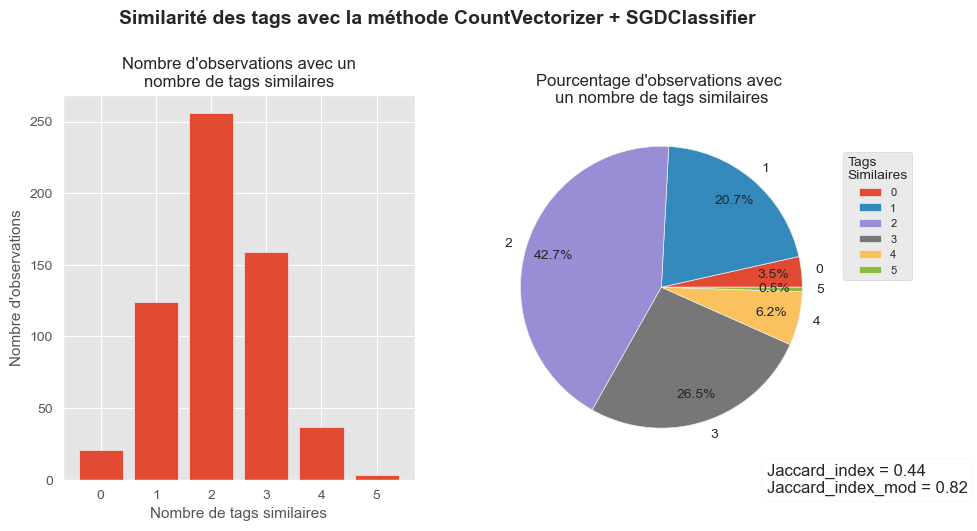

In [270]:
plot_similar_tags(true_tags_sgd, tags_SGDC, 'CountVectorizer + SGDClassifier')

## <font color="#114b98" id="section_5">5. Approche supervisée : Doc2Vec</font>

### Étude sans limiter les tags proposés

In [271]:
import multiprocessing
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from tensorflow.keras import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model

In [272]:
tagged_data = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(texts_list)]
d2v_model = Doc2Vec(tagged_data, vector_size=100, window=2, min_count=1, workers=4)
sentence_vectors = [d2v_model.infer_vector(sent) for sent in texts_list]
similar_sentences = [d2v_model.docvecs.most_similar([vec], topn=5) for vec in sentence_vectors]
pred_tags_d2v = [[texts_list[int(index)][0] for index, similarity in sim_sents] for sim_sents in similar_sentences]
pred_tags_d2v[0:5]

[['directory', 'linux', 'python', 'eclipse', 'python'],
 ['jdbc', 'post', 'jpa', 'sqlite', 'java'],
 ['jquery', 'xml', 'xml', 'xml', 'apache'],
 ['session', 'wordpress', 'file', 'websocket', 'html'],
 ['ssl', 'certificate', 'ssl', 'certificate', 'certificate']]

In [273]:
tags_list[0:5]

[['python', 'path', 'directory', 'cross-platform'],
 ['mysql', 'sql', 'database', 'go', 'tdd'],
 ['java', 'xml', 'spring', 'tomcat'],
 ['javascript', 'php', 'laravel', 'session', 'laravel-5'],
 ['firefox', 'ssl', 'https', 'ssl-certificate']]

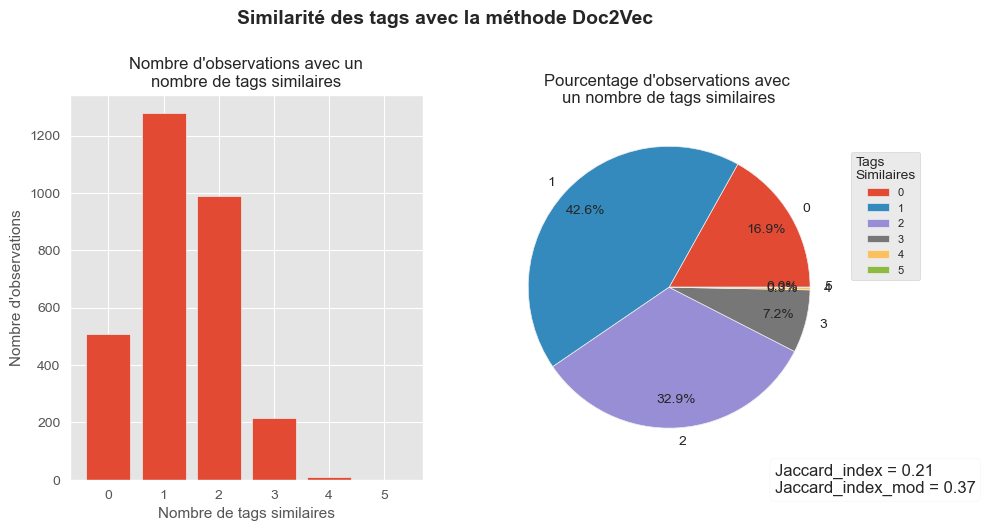

In [274]:
plot_similar_tags(tags_list, pred_tags_d2v, 'Doc2Vec')

### Étude avec ajout d'un réseau de neurones

In [277]:
encoded_sentences = np.array([d2v_model.docvecs[sent.tags[0]] for sent in tagged_data])
train_sentences, test_sentences, train_tags, test_tags = train_test_split(encoded_sentences, tags_mlb, test_size=0.2, random_state=0)

d2v_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

d2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

d2v_nn_model.summary()

In [280]:
plot_model(d2v_nn_model, to_file='d2v_nn_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [281]:
history = d2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=100, batch_size=32, 
                           validation_data=(test_sentences, test_tags),
                           workers=multiprocessing.cpu_count())

Epoch 1/100
75/75 [==============================] - 5s 17ms/step - loss: 0.7292 - accuracy: 0.0012 - val_loss: 0.6164 - val_accuracy: 0.0067
Epoch 2/100
75/75 [==============================] - 1s 12ms/step - loss: 0.5208 - accuracy: 0.0108 - val_loss: 0.3254 - val_accuracy: 0.1817
Epoch 3/100
75/75 [==============================] - 1s 12ms/step - loss: 0.2164 - accuracy: 0.0737 - val_loss: 0.1147 - val_accuracy: 0.0217
Epoch 4/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0955 - accuracy: 0.1204 - val_loss: 0.0610 - val_accuracy: 0.1933
Epoch 5/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0649 - accuracy: 0.1400 - val_loss: 0.0524 - val_accuracy: 0.2167
Epoch 6/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0553 - accuracy: 0.1367 - val_loss: 0.0468 - val_accuracy: 0.1767
Epoch 7/100
75/75 [==============================] - 1s 12ms/step - loss: 0.0508 - accuracy: 0.1488 - val_loss: 0.0442 - val_accuracy: 0.2133
Epoch 

75/75 [==============================] - 1s 11ms/step - loss: 0.0331 - accuracy: 0.2212 - val_loss: 0.0306 - val_accuracy: 0.2633
Epoch 59/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0331 - accuracy: 0.2313 - val_loss: 0.0306 - val_accuracy: 0.2917
Epoch 60/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0327 - accuracy: 0.2396 - val_loss: 0.0305 - val_accuracy: 0.2667
Epoch 61/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0327 - accuracy: 0.2417 - val_loss: 0.0305 - val_accuracy: 0.2567
Epoch 62/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0326 - accuracy: 0.2179 - val_loss: 0.0303 - val_accuracy: 0.2700
Epoch 63/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0326 - accuracy: 0.2200 - val_loss: 0.0303 - val_accuracy: 0.2483
Epoch 64/100
75/75 [==============================] - 1s 11ms/step - loss: 0.0325 - accuracy: 0.2283 - val_loss: 0.0303 - val_accuracy: 0.2783
Epoch 65/100

In [282]:
def plot_epochs(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='lower right')
    
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper right')
    
    plt.show()

plot_epochs(history)

In [284]:
pred_probs_d2v_500_nn = d2v_nn_model.predict(test_sentences)

19/19 [==============================] - 0s 4ms/step


In [285]:
pred_tags_d2v_500_nn = []
for sentence_probs in pred_probs_d2v_500_nn:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_d2v_500_nn.append([mlb.classes_[i] for i in top_indexes])
pred_tags_d2v_500_nn[0:5]

[['php', 'session', 'mysql', 'laravel', 'express'],
 ['php', 'bash', 'javascript', 'html', 'apache'],
 ['php', 'shell', 'python', 'c++', 'c#'],
 ['json', 'ajax', 'jquery', 'javascript', 'php'],
 ['java', 'eclipse', 'android', 'gradle', 'android-studio']]

In [286]:
tags_list_dv = mlb.inverse_transform(test_tags)
tags_list_dv[0:5]

[('encryption', 'security', 'php', 'javascript'),
 ('shell', 'bash', 'apache', 'php'),
 ('python', 'python-3.x', 'cryptography', 'hash'),
 ('jquery', 'json', 'ajax', 'ruby-on-rails'),
 ('java', 'junit', 'eclipse', 'android')]

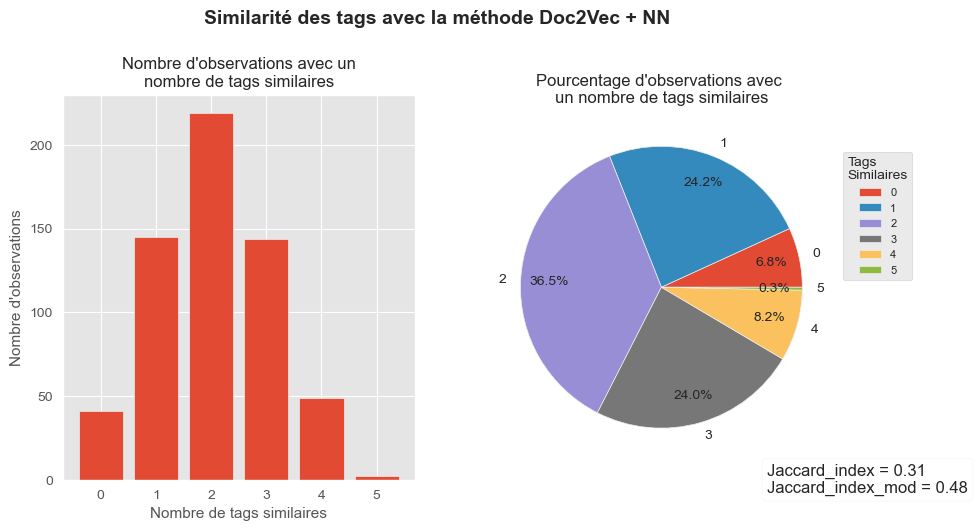

In [287]:
plot_similar_tags(tags_list_dv, pred_tags_d2v_500_nn, 'Doc2Vec + NN')

## <font color="#114b98" id="section_6">6. Approche supervisée : Word2Vec</font>

In [288]:
from gensim.models import Word2Vec

In [ ]:
w2v_model = Word2Vec(texts_list, vector_size=100, window=2, min_count=1, workers=4)

encoded_sentences = []
for sentence in texts_list:
    sentence_vector = np.zeros(100)
    for word in sentence:
        if word in w2v_model.wv:
            sentence_vector += w2v_model.wv[word]
    encoded_sentences.append(sentence_vector)
encoded_sentences = np.array(encoded_sentences)

train_sentences, test_sentences, train_tags, test_tags = train_test_split(encoded_sentences, tags_mlb, test_size=0.2, random_state=0)

w2v_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(100,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

w2v_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [294]:
plot_model(w2v_nn_model, to_file='w2v_nn_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [295]:
history = w2v_nn_model.fit(train_sentences, train_tags, verbose=1, 
                           epochs=150, batch_size=32, 
                           validation_data=(test_sentences, test_tags))

Epoch 1/150
75/75 [==============================] - 4s 15ms/step - loss: 0.7235 - accuracy: 0.0063 - val_loss: 0.5972 - val_accuracy: 0.0467
Epoch 2/150
75/75 [==============================] - 1s 10ms/step - loss: 0.5097 - accuracy: 0.0400 - val_loss: 0.2734 - val_accuracy: 0.1917
Epoch 3/150
75/75 [==============================] - 1s 10ms/step - loss: 0.2116 - accuracy: 0.1388 - val_loss: 0.0997 - val_accuracy: 0.1500
Epoch 4/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0932 - accuracy: 0.1700 - val_loss: 0.0592 - val_accuracy: 0.1583
Epoch 5/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0620 - accuracy: 0.1817 - val_loss: 0.0478 - val_accuracy: 0.2083
Epoch 6/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0528 - accuracy: 0.1850 - val_loss: 0.0442 - val_accuracy: 0.2050
Epoch 7/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0486 - accuracy: 0.1950 - val_loss: 0.0428 - val_accuracy: 0.2250
Epoch 

75/75 [==============================] - 1s 10ms/step - loss: 0.0328 - accuracy: 0.2463 - val_loss: 0.0322 - val_accuracy: 0.2533
Epoch 59/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0327 - accuracy: 0.2646 - val_loss: 0.0321 - val_accuracy: 0.2617
Epoch 60/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0327 - accuracy: 0.2567 - val_loss: 0.0321 - val_accuracy: 0.2583
Epoch 61/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0328 - accuracy: 0.2575 - val_loss: 0.0320 - val_accuracy: 0.2667
Epoch 62/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0328 - accuracy: 0.2625 - val_loss: 0.0322 - val_accuracy: 0.2617
Epoch 63/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0327 - accuracy: 0.2488 - val_loss: 0.0320 - val_accuracy: 0.2500
Epoch 64/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0326 - accuracy: 0.2550 - val_loss: 0.0318 - val_accuracy: 0.2450
Epoch 65/150

75/75 [==============================] - 1s 10ms/step - loss: 0.0294 - accuracy: 0.2646 - val_loss: 0.0292 - val_accuracy: 0.2533
Epoch 116/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0296 - accuracy: 0.2725 - val_loss: 0.0291 - val_accuracy: 0.2700
Epoch 117/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0293 - accuracy: 0.2704 - val_loss: 0.0290 - val_accuracy: 0.2483
Epoch 118/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0294 - accuracy: 0.2650 - val_loss: 0.0289 - val_accuracy: 0.2700
Epoch 119/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0294 - accuracy: 0.2654 - val_loss: 0.0288 - val_accuracy: 0.2800
Epoch 120/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0293 - accuracy: 0.2717 - val_loss: 0.0290 - val_accuracy: 0.2650
Epoch 121/150
75/75 [==============================] - 1s 10ms/step - loss: 0.0294 - accuracy: 0.2683 - val_loss: 0.0289 - val_accuracy: 0.2717
Epoch 

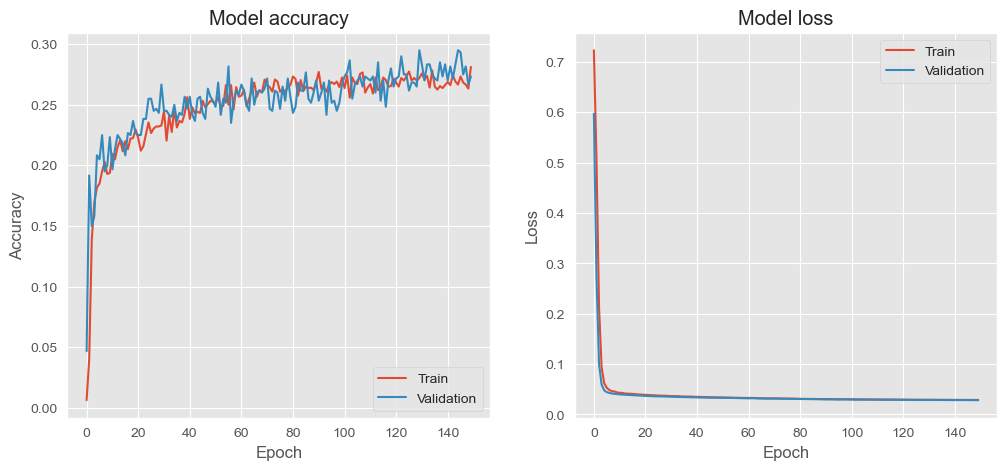

In [296]:
plot_epochs(history)

In [297]:
pred_probs_w2v_nn = w2v_nn_model.predict(test_sentences)

19/19 [==============================] - 0s 3ms/step


In [298]:
pred_tags_w2v_nn = []
for sentence_probs in pred_probs_w2v_nn:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_w2v_nn.append([mlb.classes_[i] for i in top_indexes])
pred_tags_w2v_nn[0:5]

[['php', 'javascript', 'laravel', 'session', 'security'],
 ['php', 'bash', 'apache', 'linux', 'shell'],
 ['python', 'numpy', 'function', 'python-3.x', 'scipy'],
 ['json', 'jquery', 'ajax', 'javascript', 'php'],
 ['java', 'android', 'eclipse', 'gradle', 'android-studio']]

In [299]:
true_tags_wv = mlb.inverse_transform(test_tags)
true_tags_wv[0:5]

[('encryption', 'security', 'php', 'javascript'),
 ('shell', 'bash', 'apache', 'php'),
 ('python', 'python-3.x', 'cryptography', 'hash'),
 ('jquery', 'json', 'ajax', 'ruby-on-rails'),
 ('java', 'junit', 'eclipse', 'android')]

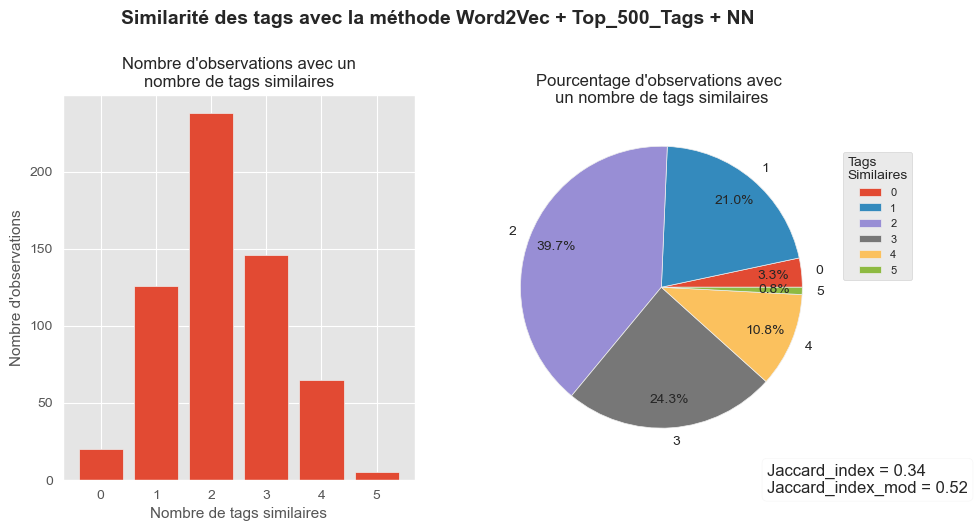

In [300]:
plot_similar_tags(true_tags_wv, pred_tags_w2v_nn, 'Word2Vec + NN')

## <font color="#114b98" id="section_7">7. Approche supervisée : BERT</font>

In [301]:
from keras.layers import Flatten
from transformers import BertModel, BertTokenizer

In [ ]:
model = BertModel.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

MAX_LEN = 510
bert_sentences = [s[:MAX_LEN] for s in texts_list]

encoded_sentences = []
for sent in tqdm(bert_sentences, ascii=' >='):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
    encoded_sentences.append(encoded_sent)
encoded_sentences = np.array(encoded_sentences)

In [ ]:
train_sentences, test_sentences, train_tags, test_tags = train_test_split(
    encoded_sentences,
    tags_mlb,
    test_size=0.2,
    random_state=42
)

bert_nn_model = Sequential([
    Flatten(input_shape=(1, 768)),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

bert_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

bert_nn_model.summary()

In [309]:
plot_model(bert_nn_model, to_file='bert_nn_model.png', show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [310]:
history = bert_nn_model.fit(train_sentences, train_tags, verbose=1, 
                            epochs=150, batch_size=32, 
                            validation_data=(test_sentences, test_tags), 
                            workers=multiprocessing.cpu_count())

Epoch 1/150
75/75 [==============================] - 6s 26ms/step - loss: 0.7274 - accuracy: 0.0037 - val_loss: 0.6105 - val_accuracy: 0.0167
Epoch 2/150
75/75 [==============================] - 2s 22ms/step - loss: 0.5113 - accuracy: 0.0317 - val_loss: 0.3034 - val_accuracy: 0.1633
Epoch 3/150
75/75 [==============================] - 2s 20ms/step - loss: 0.2143 - accuracy: 0.0946 - val_loss: 0.0926 - val_accuracy: 0.1400
Epoch 4/150
75/75 [==============================] - 2s 21ms/step - loss: 0.0955 - accuracy: 0.1271 - val_loss: 0.0557 - val_accuracy: 0.1467
Epoch 5/150
75/75 [==============================] - 2s 22ms/step - loss: 0.0641 - accuracy: 0.1513 - val_loss: 0.0466 - val_accuracy: 0.1750
Epoch 6/150
75/75 [==============================] - 2s 21ms/step - loss: 0.0530 - accuracy: 0.1538 - val_loss: 0.0432 - val_accuracy: 0.1800
Epoch 7/150
75/75 [==============================] - 2s 23ms/step - loss: 0.0491 - accuracy: 0.1696 - val_loss: 0.0421 - val_accuracy: 0.1967
Epoch 

75/75 [==============================] - 2s 24ms/step - loss: 0.0312 - accuracy: 0.2754 - val_loss: 0.0306 - val_accuracy: 0.3067
Epoch 59/150
75/75 [==============================] - 2s 20ms/step - loss: 0.0310 - accuracy: 0.2833 - val_loss: 0.0305 - val_accuracy: 0.2867
Epoch 60/150
75/75 [==============================] - 2s 20ms/step - loss: 0.0308 - accuracy: 0.2833 - val_loss: 0.0303 - val_accuracy: 0.3117
Epoch 61/150
75/75 [==============================] - 2s 20ms/step - loss: 0.0307 - accuracy: 0.2804 - val_loss: 0.0305 - val_accuracy: 0.3050
Epoch 62/150
75/75 [==============================] - 2s 22ms/step - loss: 0.0306 - accuracy: 0.2883 - val_loss: 0.0303 - val_accuracy: 0.3067
Epoch 63/150
75/75 [==============================] - 2s 23ms/step - loss: 0.0305 - accuracy: 0.2862 - val_loss: 0.0302 - val_accuracy: 0.3017
Epoch 64/150
75/75 [==============================] - 2s 25ms/step - loss: 0.0304 - accuracy: 0.2954 - val_loss: 0.0302 - val_accuracy: 0.3100
Epoch 65/150

75/75 [==============================] - 1s 20ms/step - loss: 0.0270 - accuracy: 0.3004 - val_loss: 0.0290 - val_accuracy: 0.3117
Epoch 116/150
75/75 [==============================] - 1s 20ms/step - loss: 0.0270 - accuracy: 0.3008 - val_loss: 0.0291 - val_accuracy: 0.3100
Epoch 117/150
75/75 [==============================] - 1s 20ms/step - loss: 0.0270 - accuracy: 0.2875 - val_loss: 0.0293 - val_accuracy: 0.2983
Epoch 118/150
75/75 [==============================] - 1s 20ms/step - loss: 0.0270 - accuracy: 0.3033 - val_loss: 0.0290 - val_accuracy: 0.3050
Epoch 119/150
75/75 [==============================] - 2s 21ms/step - loss: 0.0268 - accuracy: 0.3150 - val_loss: 0.0292 - val_accuracy: 0.2983
Epoch 120/150
75/75 [==============================] - 2s 21ms/step - loss: 0.0268 - accuracy: 0.2979 - val_loss: 0.0292 - val_accuracy: 0.2933
Epoch 121/150
75/75 [==============================] - 2s 21ms/step - loss: 0.0268 - accuracy: 0.2992 - val_loss: 0.0291 - val_accuracy: 0.3167
Epoch 

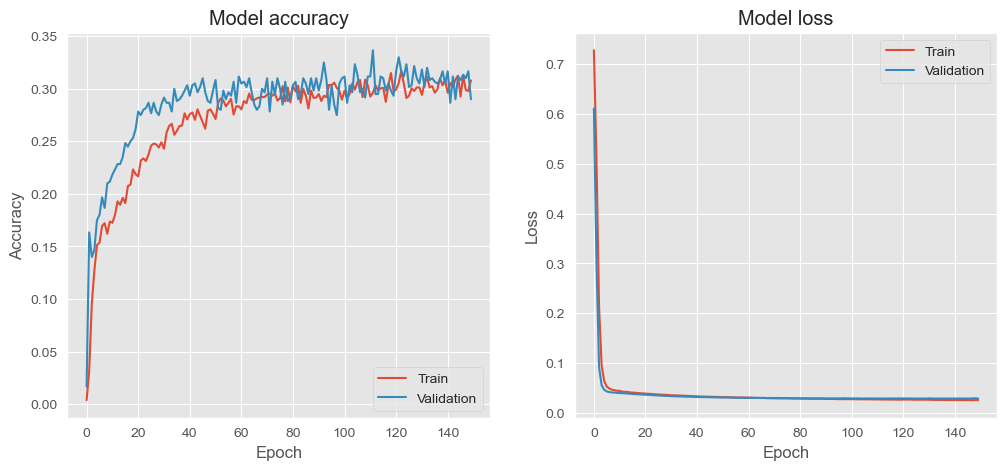

In [311]:
plot_epochs(history)

In [312]:
bert_pred_probs = bert_nn_model.predict(test_sentences)

19/19 [==============================] - 0s 6ms/step


In [313]:
pred_tags_bert = []
for sentence_probs in bert_pred_probs:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_bert.append([mlb.classes_[i] for i in top_indexes])

In [314]:
pred_tags_bert[0:5]

[['jar', 'java', 'search', 'class', 'ruby'],
 ['image', 'android', 'camera', 'java', 'iphone'],
 ['database', 'mysql', 'postgresql', 'java', 'hibernate'],
 ['jackson', 'json', 'java', 'rest', 'git'],
 ['image', 'vector', 'canvas', 'android', 'pdf']]

In [315]:
true_tags_be = mlb.inverse_transform(test_tags)
true_tags_be[0:5]

[('java', 'jar', 'algorithm', 'search', 'performance'),
 ('email', 'image', 'bitmap', 'android'),
 ('java', 'database', 'mysql', 'jdbc'),
 ('java', 'jackson', 'jersey', 'rest'),
 ('pdf', 'java', 'image', 'vector')]

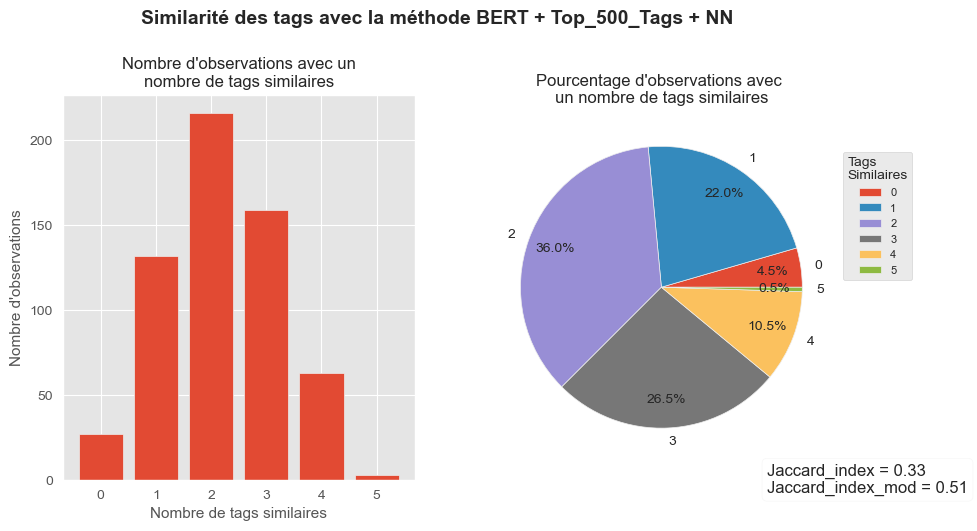

In [316]:
plot_similar_tags(true_tags_be, pred_tags_bert, 'BERT + NN')

## <font color="#114b98" id="section_8">8. Approche supervisée : USE</font>

In [317]:
import tensorflow_hub as hub

In [318]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder-large/4"

In [319]:
use_layer = hub.KerasLayer(module_url)

In [320]:
X_train, X_test, y_train, y_test = train_test_split(flat_texts, tags_mlb, test_size=0.2, random_state=42)

In [321]:
def use_encode(texts, max_len=512):
    embeddings = use_layer(texts)['outputs']
    return embeddings.numpy()

In [322]:
use_train = use_encode(X_train, max_len=100)

In [323]:
use_test = use_encode(X_test, max_len=100)

In [324]:
use_nn_model = Sequential([
    Dense(512, activation='relu', input_shape=(512,)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(len(mlb.classes_), activation='sigmoid')
])

In [325]:
use_nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = use_nn_model.fit(use_train, y_train, verbose=1, 
                           epochs=150, batch_size=32, 
                           validation_data=(use_test, y_test))

Epoch 1/150
75/75 [==============================] - 6s 27ms/step - loss: 0.7280 - accuracy: 0.0079 - val_loss: 0.5642 - val_accuracy: 0.0000e+00
Epoch 2/150
75/75 [==============================] - 1s 20ms/step - loss: 0.5164 - accuracy: 0.0821 - val_loss: 0.2883 - val_accuracy: 0.1017
Epoch 3/150
75/75 [==============================] - 1s 19ms/step - loss: 0.2143 - accuracy: 0.2021 - val_loss: 0.1132 - val_accuracy: 0.1117
Epoch 4/150
75/75 [==============================] - 1s 20ms/step - loss: 0.0936 - accuracy: 0.2358 - val_loss: 0.0607 - val_accuracy: 0.1633
Epoch 5/150
75/75 [==============================] - 1s 20ms/step - loss: 0.0609 - accuracy: 0.2392 - val_loss: 0.0500 - val_accuracy: 0.2450
Epoch 6/150
75/75 [==============================] - 1s 20ms/step - loss: 0.0512 - accuracy: 0.2442 - val_loss: 0.0428 - val_accuracy: 0.2567
Epoch 7/150
75/75 [==============================] - 1s 20ms/step - loss: 0.0455 - accuracy: 0.2458 - val_loss: 0.0395 - val_accuracy: 0.2667
Ep

75/75 [==============================] - 2s 23ms/step - loss: 0.0244 - accuracy: 0.2992 - val_loss: 0.0227 - val_accuracy: 0.3367
Epoch 59/150
75/75 [==============================] - 2s 22ms/step - loss: 0.0241 - accuracy: 0.2854 - val_loss: 0.0226 - val_accuracy: 0.3300
Epoch 60/150
75/75 [==============================] - 2s 23ms/step - loss: 0.0241 - accuracy: 0.2921 - val_loss: 0.0226 - val_accuracy: 0.3350
Epoch 61/150
75/75 [==============================] - 2s 22ms/step - loss: 0.0239 - accuracy: 0.2958 - val_loss: 0.0226 - val_accuracy: 0.3417
Epoch 62/150
75/75 [==============================] - 2s 23ms/step - loss: 0.0238 - accuracy: 0.2862 - val_loss: 0.0226 - val_accuracy: 0.3317
Epoch 63/150
75/75 [==============================] - 2s 23ms/step - loss: 0.0237 - accuracy: 0.2933 - val_loss: 0.0225 - val_accuracy: 0.3417
Epoch 64/150
75/75 [==============================] - 2s 24ms/step - loss: 0.0234 - accuracy: 0.2904 - val_loss: 0.0224 - val_accuracy: 0.3400
Epoch 65/150

In [ ]:
plot_epochs(history)

In [ ]:
pred_probs = use_nn_model.predict(use_test)

In [ ]:
pred_tags = []
for sentence_probs in pred_probs:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags.append([mlb.classes_[i] for i in top_indexes])

In [ ]:
pred_tags[0:5]

In [ ]:
true_tags_use = mlb.inverse_transform(y_test)
true_tags_use[0:5]

In [ ]:
plot_similar_tags(true_tags_use, pred_tags, 'USE + NN')

## <font color="#114b98" id="section_9">9. Choix du modèle pour le code final à déployer</font>

Nous allons maintenant comparer les différents modèles à l'aide de leurs résultats sur le dataset d'évaluation.

### TFIDF

In [ ]:
vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts_eval, min_df=min_df, max_df=max_df)
bow = vectorizer.fit_transform(flat_texts_eval)
pred_tfidf_eval = []
for i in tqdm(range(len(texts_list_eval)), ascii=' >='):
    dense_bow_matrix = bow.toarray()
    top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_tfidf_eval.append(topic_words)

### CountVectorizer

In [ ]:
vectorizer = CountVectorizer(vocabulary=vocabulary_texts_eval, min_df=min_df, max_df=max_df)
bow = vectorizer.fit_transform(flat_texts_eval)
pred_count_eval = []
for i in tqdm(range(len(texts_list_eval)), ascii=' >='):
    dense_bow_matrix = bow.toarray()
    top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
    topic_words = [list(vectorizer.vocabulary_.keys())[list(vectorizer.vocabulary_.values()).index(i)] for i in top_words_indices]
    pred_count_eval.append(topic_words)

### RAKE

Cette méthode est non supervisée et ses scores ont déjà été calculés précédemment.

### CountVectorizer + LogisticRegression

In [ ]:
X = vectorizer_CV.transform(flat_texts_eval)
y_pred_LR = ovrc_LR.predict(X)
pred_tags_LR = mlb.inverse_transform(y_pred_LR)

### CountVectorizer + SGDClassifier

In [ ]:
X = vectorizer_CV.transform(flat_texts_eval)
y_pred_SGDC = ovrc_SGDC.predict(X)
pred_tags_SGDC = mlb.inverse_transform(y_pred_SGDC)

### Doc2Vec + NN

In [ ]:
tagged_data_eval = [TaggedDocument(words=sent, tags=[str(i)]) for i, sent in enumerate(texts_list_eval)]
encoded_sentences_eval = np.array([d2v_model.infer_vector(sent.words) for sent in tagged_data_eval])
pred_probs_d2v_500_nn_eval = d2v_nn_model.predict(encoded_sentences_eval)
pred_tags_d2v = []
for sentence_probs in pred_probs_d2v_500_nn_eval:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_d2v.append([mlb.classes_[i] for i in top_indexes])

### Word2Vec + NN

In [ ]:
encoded_sentences_eval = []
for sentence in texts_list_eval:
    sentence_vector = np.zeros(100)
    for word in sentence:
        if word in w2v_model.wv:
            sentence_vector += w2v_model.wv[word]
    encoded_sentences_eval.append(sentence_vector)
encoded_sentences_eval = np.array(encoded_sentences_eval)
pred_probs_w2v_nn = w2v_nn_model.predict(encoded_sentences_eval)
pred_tags_w2v = []
for sentence_probs in pred_probs_w2v_nn:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_w2v.append([mlb.classes_[i] for i in top_indexes])

### BERT + NN

In [ ]:
bert_sentences_eval = [s[:MAX_LEN] for s in texts_list_eval]
encoded_sentences_eval = []
for sent in tqdm(bert_sentences_eval, ascii=' >='):
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    with torch.no_grad():
        encoded_sent = model(input_ids)[0].mean(dim=1).numpy()
    encoded_sentences_eval.append(encoded_sent)
encoded_sentences_eval = np.array(encoded_sentences_eval)
pred_probs_bert_eval = bert_nn_model.predict(encoded_sentences_eval)
pred_tags_bert_eval = []
for sentence_probs in pred_probs_bert_eval:
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_bert_eval.append([mlb.classes_[i] for i in top_indexes])

### USE + Neural Network

In [ ]:
use_test_eval = use_encode(flat_texts_eval, max_len=100)
pred_probs_eval = use_nn_model.predict(use_test_eval)
pred_tags_use_nn = []
for sentence_probs in tqdm(pred_probs_eval, ascii=' >='):
    top_indexes = sentence_probs.argsort()[-5:][::-1]
    pred_tags_use_nn.append([mlb.classes_[i] for i in top_indexes])

### Comparaisons

In [ ]:
models_tags_lists = [pred_tfidf_eval, pred_count_eval, rake_keywords,
                     pred_tags_LR, pred_tags_SGDC, pred_tags_d2v, 
                     pred_tags_w2v, pred_tags_bert_eval, pred_tags_use_nn]

In [ ]:
models_names = ['TFIDF', 'CV', 'RAKE',
                'CV + LR', 'CV + SGDC', 'D2V + NN',
                'W2V + NN', 'BERT + NN', 'USE + NN']

In [ ]:
def plot_tag_comparison(true_tags, models_tags_lists, models_names):
    n = len(models_tags_lists)
    rows = (n + 2) // 3
    fig, axs = plt.subplots(rows, 3, figsize=(16, 14), squeeze=False)
    fig.suptitle("Pourcentage d'observations avec tags similaires pour chaque méthode",
                 fontsize=16, fontweight='bold', y=0.93)    

    jaccard_scores = []
    jaccard_scores_mod = []
    mean_nb_tags_list = [] 

    for i, pred_tags in enumerate(models_tags_lists):
        mean_score = calculate_scores(true_tags, pred_tags)
        mean_score_mod = calculate_scores_mod(true_tags, pred_tags)
        mean_nb_tags = mean([len(tags) for tags in pred_tags])

        jaccard_scores.append(mean_score)
        jaccard_scores_mod.append(mean_score_mod)        
        mean_nb_tags_list.append(mean_nb_tags)
        
        counter = Counter([len(set(t) & set(p)) for t, p in zip(true_tags, pred_tags)])
        counter = dict(sorted(counter.items()))
        keys = set(range(0, 6))
        missing_keys = keys - set(counter.keys())
        for key in missing_keys:
            counter[key] = 0
        sorted_counter = dict(sorted(counter.items()))

        row = i // 3
        col = i % 3
        axs[row, col].pie(sorted_counter.values(),
                           labels=sorted_counter.keys(),
                           autopct='%1.1f%%', pctdistance=0.8, radius=0.8)
        if i == 0:
            axs[row, col].legend(title='Similar\nTags',
                          bbox_to_anchor=(0, 1),
                          prop={'size': 8}, 
                          title_fontsize=10)
        axs[row, col].set_title(models_names[i], fontweight='bold', y=0.9)
        
        textstr = (f'Jaccard index = {mean_score:.2f}\n'
                   f'Jaccard index mod = {mean_score_mod:.2f}\n'
                   f'Mean nb Tags = {mean_nb_tags:.1f}\n')
        props = dict(boxstyle='round', facecolor='white', alpha=0.5)
        axs[row, col].text(0.6, 0.15, textstr, transform=axs[row, col].transAxes,
                           fontsize=12, verticalalignment='top', bbox=props)

    plt.show()
    return jaccard_scores, jaccard_scores_mod, mean_nb_tags_list

In [ ]:
jaccard_scores, jaccard_scores_mod, mean_nb_tags_list = plot_tag_comparison(tags_list_eval,
                                                                            models_tags_lists,
                                                                            models_names)

In [ ]:
data = {
    'models_names': models_names,
    'jaccard_scores': jaccard_scores,
    'jaccard_scores_mod': jaccard_scores_mod,
    'mean_nb_tags': mean_nb_tags_list
}

In [ ]:
sns.set_style('whitegrid')
fig= plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[1, 0.2], hspace=0.4)
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
fig.suptitle("Comparaison des Jaccard Scores et du nombre de tags générés par les modèles",
                 fontsize=14, fontweight='bold', y=0.93)    

sns.barplot(x='models_names', y='jaccard_scores', data=data, ax=ax1, color='orange', alpha=0.7, label='Jaccard scores', zorder=2)
sns.barplot(x='models_names', y='jaccard_scores_mod', data=data, ax=ax1, color='skyblue', alpha=0.7, label='Jaccard scores modifiés', zorder=1)

ax1.set_ylabel('Scores')
ax1.legend()

sns.barplot(x='models_names', y='mean_nb_tags', data=data, ax=ax2, color='lightgreen', alpha=0.7)
ax2.set_xticklabels(models_names)
ax2.set_ylabel('Nb de tags')

plt.show()

## <font color="#114b98" id="section_10">10. Préparation de la pipeline de prédiction</font>

In [ ]:
import re
import dill
import joblib
import pickle
import html5lib
from bs4 import BeautifulSoup
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline

In [ ]:
with open(main_path + 'streamlit-app/ressources/stop_words.pkl', 'rb') as f:
    stop_words = pickle.load(f)

### SGDC Model

In [ ]:
def transform_with_vectorizer(x):
    return vectorizer_loaded.transform(x)

In [ ]:
# Define the pipeline
pipeline_tags = Pipeline([
    ('html_cleaner', FunctionTransformer(lambda x: BeautifulSoup(x, 'html5lib').text)),
    ('text_cleaner', FunctionTransformer(lambda x: re.sub(r'[^\w\s]', ' ', x))),
    ('tokenizer', FunctionTransformer(lambda x: word_tokenize(x))),
    ('stopword_remover', FunctionTransformer(lambda x: [word for word in x if word not in stop_words])),
    ('pos_tagger', FunctionTransformer(lambda x: [(word, pos_tag) for word, pos_tag in pos_tag(x)])),
    ('noun_filter', FunctionTransformer(lambda x: [word for word, pos_tag in x if pos_tag in ['NN', 'NNS', 'NNP', 'NNPS']])),
    ('lemmatizer', FunctionTransformer(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])),
    ('join', FunctionTransformer(lambda x: ' '.join(x))),
    ('to_list', FunctionTransformer(lambda x: [x])),
    ('vectorizer', FunctionTransformer(transform_with_vectorizer)),
    ('clf', ovrc_SGDC)
])

In [ ]:
with open(main_path + 'streamlit-app/ressources/pipeline_tags.pkl', 'wb') as file:
    dill.dump(pipeline_tags, file)

In [ ]:
joblib.dump(vectorizer_CV, main_path + 'streamlit-app/ressources/countvectorizer.joblib')

In [ ]:
joblib.dump(mlb, main_path + 'streamlit-app/ressources/multilabelbinarizer.joblib')

### CountVectorizer Model

In [ ]:
def top_words(x):
    pred_count_eval = []
    for i in range(x.shape[0]):
        dense_bow_matrix = x.toarray()
        top_words_indices = dense_bow_matrix[i].argsort()[-5:][::-1]
        top_words_values = dense_bow_matrix[i][top_words_indices]
        top_words_list = []
        for j in range(len(top_words_indices)):
            top_words_list.append((vectorizer_loaded.get_feature_names()[top_words_indices[j]], top_words_values[j]))
        pred_count_eval.append(top_words_list)
    return pred_count_eval

In [ ]:
pipeline_tags_cv = Pipeline([
    ('html_cleaner', FunctionTransformer(lambda x: BeautifulSoup(x, 'html5lib').text)),
    ('text_cleaner', FunctionTransformer(lambda x: re.sub(r'[^\w\s]', ' ', x))),
    ('tokenizer', FunctionTransformer(lambda x: word_tokenize(x))),
    ('stopword_remover', FunctionTransformer(lambda x: [word for word in x if word not in stop_words])),
    ('pos_tagger', FunctionTransformer(lambda x: [(word, pos_tag) for word, pos_tag in pos_tag(x)])),
    ('noun_filter', FunctionTransformer(lambda x: [word for word, pos_tag in x if pos_tag in ['NN', 'NNS', 'NNP', 'NNPS']])),
    ('lemmatizer', FunctionTransformer(lambda x: [WordNetLemmatizer().lemmatize(word) for word in x])),
    ('join', FunctionTransformer(lambda x: ' '.join(x))),
    ('to_list', FunctionTransformer(lambda x: [x])),
    ('vectorizer', FunctionTransformer(transform_with_vectorizer)),
    ('pred_count_eval', FunctionTransformer(lambda x: top_words(x)))
])

In [ ]:
with open(main_path + 'streamlit-app/ressources/pipeline_tags_cv.pkl', 'wb') as file:
    dill.dump(pipeline_tags_cv, file)

### USE + NN Model

In [ ]:
def use_words(x):
    pred_tags_use_nn = []
    for sentence_probs in pred_probs_eval:
        top_indexes = sentence_probs.argsort()[-5:][::-1]
        pred_tags_use_nn.append([mlb_loaded.classes_[i] for i in top_indexes])

In [ ]:
pipeline_tags_use = Pipeline([
    ('html_cleaner', FunctionTransformer(lambda x: BeautifulSoup(x, 'html5lib').text)),
    ('text_cleaner', FunctionTransformer(lambda x: re.sub(r'[^\w\s]', ' ', x))),
    ('join', FunctionTransformer(lambda x: ' '.join(x))),
    ('to_list', FunctionTransformer(lambda x: [x])),
    ('encoder', FunctionTransformer(lambda x: use_encode(x, max_len=100))),
    ('predictor', FunctionTransformer(use_nn_model))
])

In [ ]:
with open(main_path + 'streamlit-app/ressources/pipeline_tags_use.pkl', 'wb') as file:
    dill.dump(pipeline_tags_use, file)